In [1]:
# Import Libraries and Setup Directories
# Standard Library
import os
import pickle
import datetime as dt
import subprocess
import sys
import logging
import warnings

# Data Handling and Numerical Computing
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Machine Learning and Deep Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN, Input, LSTM, Dense, Dropout, Input, LayerNormalization, BatchNormalization

# Financial Data
import yfinance as yf
import pandas_datareader as web

warnings.filterwarnings('ignore')

# Ensure necessary directories exist
DATA_DIR = "data"
MODEL_DIR = "models"
for directory in [DATA_DIR, MODEL_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

# Install plotly if not already installed
def install_package(package):
    try:
        __import__(package)
        print(f"✅ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")

install_package('plotly')

# Install sentiment analysis packages
install_package('vaderSentiment')
install_package('requests')
install_package('python-dotenv')
install_package('pyyaml')

print("✅ All required packages are ready!")

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'{DATA_DIR}/stock_prediction.log'),
        logging.StreamHandler()
    ]
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Add error handling wrapper
def safe_execute(func, *args, **kwargs):
    """Safely execute functions with error handling"""
    try:
        return func(*args, **kwargs)
    except Exception as e:
        logging.error(f"Error in {func.__name__}: {str(e)}")
        raise

Created directory: data
Created directory: models
✅ plotly is already installed
✅ vaderSentiment is already installed
✅ requests is already installed
Installing python-dotenv...
✅ python-dotenv installed successfully
Installing pyyaml...
✅ pyyaml installed successfully
✅ All required packages are ready!


In [2]:
# Sentiment Analysis Infrastructure Setup
import json
import time
import requests
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import yaml
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Create sentiment cache directory
SENTIMENT_CACHE_DIR = "data/sentiment_cache"
if not os.path.exists(SENTIMENT_CACHE_DIR):
    os.makedirs(SENTIMENT_CACHE_DIR)
    print(f"Created directory: {SENTIMENT_CACHE_DIR}")

@dataclass
class SentimentScore:
    """Data class for sentiment scores"""
    compound: float  # Overall sentiment (-1 to 1)
    positive: float  # Positive component (0 to 1)
    negative: float  # Negative component (0 to 1)
    neutral: float   # Neutral component (0 to 1)
    confidence: float = 1.0  # Confidence in the score (0 to 1)

@dataclass
class NewsArticle:
    """Data class for news articles"""
    title: str
    content: str
    published_at: datetime
    source: str
    url: str
    relevance_score: float = 1.0

@dataclass
class SocialPost:
    """Data class for social media posts"""
    text: str
    created_at: datetime
    platform: str
    author: str
    engagement_metrics: dict
    is_spam: bool = False

@dataclass
class SentimentConfig:
    """Configuration for sentiment analysis"""
    enabled: bool = True
    news_sources: List[str] = field(default_factory=lambda: ['newsapi'])
    social_platforms: List[str] = field(default_factory=lambda: ['twitter'])
    sentiment_analyzer: str = 'vader'
    cache_duration_hours: int = 24
    max_articles_per_day: int = 50
    max_posts_per_day: int = 100

# Custom exceptions
class SentimentAnalysisError(Exception):
    """Base exception for sentiment analysis errors"""
    pass

class APIRateLimitError(SentimentAnalysisError):
    """Raised when API rate limits are exceeded"""
    pass

class DataQualityError(SentimentAnalysisError):
    """Raised when sentiment data quality is poor"""
    pass

print("✅ Sentiment analysis infrastructure setup complete!")

Created directory: data/sentiment_cache
✅ Sentiment analysis infrastructure setup complete!


In [3]:
# Sentiment Analyzer Implementation
class SentimentAnalyzer:
    """Processes text content to extract sentiment scores"""
    
    def __init__(self, analyzer_type: str = 'vader'):
        self.analyzer_type = analyzer_type
        if analyzer_type == 'vader':
            self.analyzer = SentimentIntensityAnalyzer()
        else:
            raise ValueError(f"Unsupported analyzer type: {analyzer_type}")
    
    def _preprocess_text(self, text: str) -> str:
        """Preprocess text for financial sentiment analysis"""
        if not text:
            return ""
        
        # Basic cleaning
        text = text.strip()
        # Remove excessive whitespace
        text = ' '.join(text.split())
        return text
    
    def analyze_text(self, text: str) -> SentimentScore:
        """Analyze sentiment of a single text"""
        try:
            processed_text = self._preprocess_text(text)
            if not processed_text:
                return SentimentScore(0.0, 0.0, 0.0, 1.0, 0.0)
            
            scores = self.analyzer.polarity_scores(processed_text)
            return SentimentScore(
                compound=scores['compound'],
                positive=scores['pos'],
                negative=scores['neg'],
                neutral=scores['neu'],
                confidence=1.0
            )
        except Exception as e:
            logging.error(f"Error analyzing text sentiment: {e}")
            return SentimentScore(0.0, 0.0, 0.0, 1.0, 0.0)
    
    def batch_analyze(self, texts: List[str]) -> List[SentimentScore]:
        """Analyze sentiment of multiple texts"""
        return [self.analyze_text(text) for text in texts]

print("✅ SentimentAnalyzer class implemented!")

✅ SentimentAnalyzer class implemented!


In [4]:
# News API Client Implementation
class NewsAPIClient:
    """Fetches news articles from external APIs"""
    
    def __init__(self, api_key: str = None, base_url: str = "https://newsapi.org/v2"):
        self.api_key = api_key or os.getenv('NEWS_API_KEY')
        self.base_url = base_url
        self.session = requests.Session()
        if self.api_key:
            self.session.headers.update({'X-API-Key': self.api_key})
    
    def _build_query(self, symbol: str) -> str:
        """Build search query for company news"""
        company_queries = {
            'CBA.AX': 'Commonwealth Bank OR CBA OR "Commonwealth Bank of Australia"',
            'AAPL': 'Apple OR "Apple Inc" OR iPhone',
            'TSLA': 'Tesla OR "Tesla Inc" OR "Elon Musk"'
        }
        return company_queries.get(symbol, symbol.replace('.', ' '))
    
    def _handle_rate_limits(self, response) -> None:
        """Handle API rate limiting"""
        if response.status_code == 429:
            retry_after = int(response.headers.get('Retry-After', 60))
            logging.warning(f"Rate limit hit, waiting {retry_after} seconds")
            time.sleep(retry_after)
            raise APIRateLimitError("Rate limit exceeded")
    
    def fetch_news(self, query: str, from_date: str, to_date: str) -> List[NewsArticle]:
        """Fetch news articles for given query and date range"""
        if not self.api_key:
            logging.warning("No News API key provided, using mock data")
            return self._get_mock_news(query, from_date, to_date)
        
        try:
            params = {
                'q': query,
                'from': from_date,
                'to': to_date,
                'sortBy': 'publishedAt',
                'language': 'en',
                'pageSize': 50
            }
            
            response = self.session.get(f"{self.base_url}/everything", params=params)
            self._handle_rate_limits(response)
            response.raise_for_status()
            
            data = response.json()
            articles = []
            
            for article_data in data.get('articles', []):
                try:
                    article = NewsArticle(
                        title=article_data.get('title', ''),
                        content=article_data.get('description', '') or article_data.get('content', ''),
                        published_at=datetime.fromisoformat(article_data['publishedAt'].replace('Z', '+00:00')),
                        source=article_data.get('source', {}).get('name', 'Unknown'),
                        url=article_data.get('url', ''),
                        relevance_score=1.0
                    )
                    articles.append(article)
                except Exception as e:
                    logging.warning(f"Error parsing article: {e}")
                    continue
            
            return articles
            
        except Exception as e:
            logging.error(f"Error fetching news: {e}")
            return self._get_mock_news(query, from_date, to_date)
    
    def _get_mock_news(self, query: str, from_date: str, to_date: str) -> List[NewsArticle]:
        """Generate mock news data for testing"""
        mock_articles = [
            NewsArticle(
                title=f"Commonwealth Bank reports strong quarterly results",
                content="Commonwealth Bank announced strong financial performance with increased profits and customer growth.",
                published_at=datetime.strptime(from_date, '%Y-%m-%d') + timedelta(days=1),
                source="Financial Review",
                url="https://example.com/news1",
                relevance_score=0.9
            ),
            NewsArticle(
                title=f"CBA faces regulatory scrutiny over lending practices",
                content="Banking regulator announces investigation into Commonwealth Bank's lending procedures.",
                published_at=datetime.strptime(from_date, '%Y-%m-%d') + timedelta(days=2),
                source="ABC News",
                url="https://example.com/news2",
                relevance_score=0.8
            )
        ]
        return mock_articles

print("✅ NewsAPIClient class implemented!")

✅ NewsAPIClient class implemented!


In [5]:
# Social Media Client Implementation
class SocialMediaClient:
    """Collects social media posts mentioning the target company"""
    
    def __init__(self, platform: str = 'twitter', credentials: dict = None):
        self.platform = platform
        self.credentials = credentials or {}
    
    def _filter_relevant_posts(self, posts: List[SocialPost]) -> List[SocialPost]:
        """Filter posts for relevance to financial topics"""
        financial_keywords = ['stock', 'price', 'earnings', 'profit', 'loss', 'dividend', 'market', 'trading']
        relevant_posts = []
        
        for post in posts:
            text_lower = post.text.lower()
            if any(keyword in text_lower for keyword in financial_keywords):
                relevant_posts.append(post)
        
        return relevant_posts
    
    def _detect_spam(self, post: SocialPost) -> bool:
        """Simple spam detection"""
        spam_indicators = ['buy now', 'guaranteed profit', 'risk free', 'get rich quick']
        text_lower = post.text.lower()
        return any(indicator in text_lower for indicator in spam_indicators)
    
    def fetch_posts(self, query: str, start_date: str, end_date: str) -> List[SocialPost]:
        """Fetch social media posts for given query and date range"""
        # For now, return mock data since we don't have API access
        return self._get_mock_posts(query, start_date, end_date)
    
    def _get_mock_posts(self, query: str, start_date: str, end_date: str) -> List[SocialPost]:
        """Generate mock social media posts for testing"""
        mock_posts = [
            SocialPost(
                text="CBA stock looking strong today! Great earnings report 📈",
                created_at=datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=1),
                platform="twitter",
                author="investor123",
                engagement_metrics={"likes": 45, "retweets": 12},
                is_spam=False
            ),
            SocialPost(
                text="Not happy with Commonwealth Bank's latest fees increase 😠",
                created_at=datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=2),
                platform="twitter",
                author="customer456",
                engagement_metrics={"likes": 23, "retweets": 8},
                is_spam=False
            ),
            SocialPost(
                text="CBA dividend announcement coming soon. Expecting good results!",
                created_at=datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=3),
                platform="twitter",
                author="trader789",
                engagement_metrics={"likes": 67, "retweets": 15},
                is_spam=False
            )
        ]
        
        # Filter for relevance and spam
        relevant_posts = self._filter_relevant_posts(mock_posts)
        clean_posts = [post for post in relevant_posts if not self._detect_spam(post)]
        
        return clean_posts

print("✅ SocialMediaClient class implemented!")

✅ SocialMediaClient class implemented!


In [6]:
# Sentiment Data Collector Implementation
class SentimentDataCollector:
    """Orchestrates collection of sentiment data from multiple sources"""
    
    def __init__(self, config: SentimentConfig):
        self.config = config
        self.sentiment_analyzer = SentimentAnalyzer(config.sentiment_analyzer)
        self.news_client = NewsAPIClient()
        self.social_client = SocialMediaClient()
    
    def get_cached_data(self, symbol: str, date_range: tuple) -> Optional[pd.DataFrame]:
        """Check for cached sentiment data"""
        start_date, end_date = date_range
        cache_file = f"{SENTIMENT_CACHE_DIR}/{symbol}_{start_date}_{end_date}_sentiment.csv"
        
        if os.path.exists(cache_file):
            # Check if cache is still valid
            file_age = time.time() - os.path.getmtime(cache_file)
            if file_age < (self.config.cache_duration_hours * 3600):
                try:
                    df = pd.read_csv(cache_file)
                    df['Date'] = pd.to_datetime(df['Date'])
                    logging.info(f"Using cached sentiment data for {symbol}")
                    return df
                except Exception as e:
                    logging.warning(f"Error reading cache file: {e}")
        
        return None
    
    def save_to_cache(self, data: pd.DataFrame, symbol: str, date_range: tuple) -> None:
        """Save sentiment data to cache"""
        start_date, end_date = date_range
        cache_file = f"{SENTIMENT_CACHE_DIR}/{symbol}_{start_date}_{end_date}_sentiment.csv"
        
        try:
            data.to_csv(cache_file, index=False)
            logging.info(f"Sentiment data cached to {cache_file}")
        except Exception as e:
            logging.error(f"Error saving to cache: {e}")
    
    def _merge_sources(self, news_sentiment: pd.DataFrame, social_sentiment: pd.DataFrame) -> pd.DataFrame:
        """Combine news and social media sentiment"""
        # Merge on date, using outer join to keep all dates
        merged = pd.merge(news_sentiment, social_sentiment, on='Date', how='outer', suffixes=('_news', '_social'))
        
        # Calculate combined sentiment (weighted average)
        news_weight = 0.6  # News typically more reliable
        social_weight = 0.4
        
        merged['sentiment_compound'] = (
            merged['sentiment_compound_news'].fillna(0) * news_weight +
            merged['sentiment_compound_social'].fillna(0) * social_weight
        )
        
        merged['sentiment_positive'] = (
            merged['sentiment_positive_news'].fillna(0) * news_weight +
            merged['sentiment_positive_social'].fillna(0) * social_weight
        )
        
        merged['sentiment_negative'] = (
            merged['sentiment_negative_news'].fillna(0) * news_weight +
            merged['sentiment_negative_social'].fillna(0) * social_weight
        )
        
        merged['sentiment_neutral'] = (
            merged['sentiment_neutral_news'].fillna(1) * news_weight +
            merged['sentiment_neutral_social'].fillna(1) * social_weight
        )
        
        # Add volume metrics
        merged['news_volume'] = merged['news_volume'].fillna(0)
        merged['social_volume'] = merged['social_volume'].fillna(0)
        merged['total_volume'] = merged['news_volume'] + merged['social_volume']
        
        # Select final columns
        final_columns = ['Date', 'sentiment_compound', 'sentiment_positive', 'sentiment_negative', 
                        'sentiment_neutral', 'news_volume', 'social_volume', 'total_volume']
        
        return merged[final_columns]
    
    def _handle_missing_dates(self, sentiment_df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
        """Fill gaps in sentiment data"""
        # Create complete date range
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        complete_df = pd.DataFrame({'Date': date_range})
        
        # Merge with sentiment data
        merged = pd.merge(complete_df, sentiment_df, on='Date', how='left')
        
        # Forward fill sentiment scores
        sentiment_columns = ['sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral']
        for col in sentiment_columns:
            merged[col] = merged[col].fillna(method='ffill').fillna(0.0)
        
        # Fill volume with 0
        volume_columns = ['news_volume', 'social_volume', 'total_volume']
        for col in volume_columns:
            merged[col] = merged[col].fillna(0)
        
        return merged
    
    def collect_sentiment_data(self, symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
        """Main entry point for sentiment collection"""
        if not self.config.enabled:
            logging.info("Sentiment analysis disabled, returning neutral sentiment")
            return self._create_neutral_sentiment(start_date, end_date)
        
        date_range = (start_date, end_date)
        
        # Check cache first
        cached_data = self.get_cached_data(symbol, date_range)
        if cached_data is not None:
            return cached_data
        
        logging.info(f"Collecting sentiment data for {symbol} from {start_date} to {end_date}")
        
        try:
            # Collect news sentiment
            news_sentiment = self._collect_news_sentiment(symbol, start_date, end_date)
            
            # Collect social media sentiment
            social_sentiment = self._collect_social_sentiment(symbol, start_date, end_date)
            
            # Merge sources
            combined_sentiment = self._merge_sources(news_sentiment, social_sentiment)
            
            # Handle missing dates
            final_sentiment = self._handle_missing_dates(combined_sentiment, start_date, end_date)
            
            # Cache the results
            self.save_to_cache(final_sentiment, symbol, date_range)
            
            return final_sentiment
            
        except Exception as e:
            logging.error(f"Error collecting sentiment data: {e}")
            return self._create_neutral_sentiment(start_date, end_date)
    
    def _collect_news_sentiment(self, symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
        """Collect and analyze news sentiment"""
        query = self.news_client._build_query(symbol)
        articles = self.news_client.fetch_news(query, start_date, end_date)
        
        if not articles:
            return self._create_empty_sentiment_df()
        
        # Analyze sentiment for each article
        daily_sentiment = {}
        
        for article in articles:
            date_key = article.published_at.date()
            text = f"{article.title} {article.content}"
            sentiment = self.sentiment_analyzer.analyze_text(text)
            
            if date_key not in daily_sentiment:
                daily_sentiment[date_key] = []
            
            daily_sentiment[date_key].append(sentiment)
        
        # Aggregate daily sentiment
        sentiment_data = []
        for date, sentiments in daily_sentiment.items():
            avg_compound = np.mean([s.compound for s in sentiments])
            avg_positive = np.mean([s.positive for s in sentiments])
            avg_negative = np.mean([s.negative for s in sentiments])
            avg_neutral = np.mean([s.neutral for s in sentiments])
            
            sentiment_data.append({
                'Date': pd.to_datetime(date),
                'sentiment_compound_news': avg_compound,
                'sentiment_positive_news': avg_positive,
                'sentiment_negative_news': avg_negative,
                'sentiment_neutral_news': avg_neutral,
                'news_volume': len(sentiments)
            })
        
        return pd.DataFrame(sentiment_data)
    
    def _collect_social_sentiment(self, symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
        """Collect and analyze social media sentiment"""
        query = symbol
        posts = self.social_client.fetch_posts(query, start_date, end_date)
        
        if not posts:
            return self._create_empty_sentiment_df()
        
        # Analyze sentiment for each post
        daily_sentiment = {}
        
        for post in posts:
            date_key = post.created_at.date()
            sentiment = self.sentiment_analyzer.analyze_text(post.text)
            
            if date_key not in daily_sentiment:
                daily_sentiment[date_key] = []
            
            daily_sentiment[date_key].append(sentiment)
        
        # Aggregate daily sentiment
        sentiment_data = []
        for date, sentiments in daily_sentiment.items():
            avg_compound = np.mean([s.compound for s in sentiments])
            avg_positive = np.mean([s.positive for s in sentiments])
            avg_negative = np.mean([s.negative for s in sentiments])
            avg_neutral = np.mean([s.neutral for s in sentiments])
            
            sentiment_data.append({
                'Date': pd.to_datetime(date),
                'sentiment_compound_social': avg_compound,
                'sentiment_positive_social': avg_positive,
                'sentiment_negative_social': avg_negative,
                'sentiment_neutral_social': avg_neutral,
                'social_volume': len(sentiments)
            })
        
        return pd.DataFrame(sentiment_data)
    
    def _create_empty_sentiment_df(self) -> pd.DataFrame:
        """Create empty sentiment dataframe"""
        return pd.DataFrame(columns=['Date', 'sentiment_compound', 'sentiment_positive', 
                                   'sentiment_negative', 'sentiment_neutral', 'news_volume', 
                                   'social_volume', 'total_volume'])
    
    def _create_neutral_sentiment(self, start_date: str, end_date: str) -> pd.DataFrame:
        """Create neutral sentiment for date range"""
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        
        return pd.DataFrame({
            'Date': date_range,
            'sentiment_compound': 0.0,
            'sentiment_positive': 0.0,
            'sentiment_negative': 0.0,
            'sentiment_neutral': 1.0,
            'news_volume': 0,
            'social_volume': 0,
            'total_volume': 0
        })

print("✅ SentimentDataCollector class implemented!")

✅ SentimentDataCollector class implemented!


In [7]:
# Ensure the necessary directories exist
DATA_DIR = "data"  # Directory to save the data
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    
# Define constants outside the loop
COMPANY = 'CBA.AX'
DEFAULT_TRAIN_START = '2020-01-01'
DEFAULT_TRAIN_END = '2023-01-01'
while True:
    try:
        # Get training start date
        TRAIN_START = input(f"Enter training start date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_START}': ")
        if not TRAIN_START.strip():
            TRAIN_START = DEFAULT_TRAIN_START
        
        # Get training end date
        TRAIN_END = input(f"Enter training end date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_END}': ")
        if not TRAIN_END.strip():
            TRAIN_END = DEFAULT_TRAIN_END
        
        # Validate date format
        start_date = dt.datetime.strptime(TRAIN_START, '%Y-%m-%d')
        end_date = dt.datetime.strptime(TRAIN_END, '%Y-%m-%d')
        
        # Validate date range
        if start_date >= end_date:
            print("Error: Training end date must be after training start date.")
            continue
        
        print(f"Using training period: {TRAIN_START} to {TRAIN_END}")
        break  # Exit the loop if everything is valid
    
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD format.")
        print(f"Using default values: {DEFAULT_TRAIN_START} to {DEFAULT_TRAIN_END}")
        TRAIN_START = DEFAULT_TRAIN_START
        TRAIN_END = DEFAULT_TRAIN_END
        break  # Or continue to ask again by removing this line

# Get the data for the stock AAPL
data = yf.download(COMPANY,TRAIN_START,TRAIN_END)
data_filename = f"{DATA_DIR}/{COMPANY}_data.csv"


# If it does not exist, save the data to the file
print(f"Saving data to {data_filename}")
data.to_csv(data_filename)
print(f"Data saved to {data_filename}")

df = pd.read_csv(data_filename, skiprows=[1,2])

# Preprocess the data
# Check for missing values and handle them properly
print("\nMissing values check:")
print(df.isnull().sum())

# Handle missing values with forward fill or interpolation
df = df.fillna(method='ffill').fillna(method='bfill')

# The columns actually contain: Date, Price, Close, High, Low, Volume
df.columns = ['Date', 'Price', 'Close', 'High', 'Low', 'Volume']

# Add after your feature columns definition
def create_technical_indicators(df):
    """Add technical indicators as features"""
    # Moving averages
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['BB_upper'] = df['MA_20'] + (df['Close'].rolling(window=20).std() * 2)
    df['BB_lower'] = df['MA_20'] - (df['Close'].rolling(window=20).std() * 2)
    
    # MACD
    exp1 = df['Close'].ewm(span=12).mean()
    exp2 = df['Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    
    # Volatility
    df['Volatility'] = df['Close'].rolling(window=20).std()
    
    return df.dropna()

# Sentiment Feature Engineering
class SentimentFeatureEngineer:
    """Converts raw sentiment scores into ML-ready features"""
    
    def __init__(self):
        self.rolling_windows = [3, 7, 14]
    
    def create_sentiment_features(self, sentiment_df: pd.DataFrame) -> pd.DataFrame:
        """Create comprehensive sentiment features"""
        df = sentiment_df.copy()
        
        # Calculate rolling sentiment averages
        df = self._calculate_rolling_sentiment(df, self.rolling_windows)
        
        # Create sentiment momentum features
        df = self._create_sentiment_momentum(df)
        
        # Create sentiment volatility features
        df = self._create_sentiment_volatility(df)
        
        return df.dropna()
    
    def _calculate_rolling_sentiment(self, df: pd.DataFrame, windows: List[int]) -> pd.DataFrame:
        """Calculate rolling averages for sentiment scores"""
        for window in windows:
            df[f'sentiment_compound_ma_{window}'] = df['sentiment_compound'].rolling(window=window).mean()
            df[f'sentiment_positive_ma_{window}'] = df['sentiment_positive'].rolling(window=window).mean()
            df[f'sentiment_negative_ma_{window}'] = df['sentiment_negative'].rolling(window=window).mean()
            df[f'sentiment_volume_ma_{window}'] = df['total_volume'].rolling(window=window).mean()
        
        return df
    
    def _create_sentiment_momentum(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create sentiment momentum (rate of change) features"""
        # 1-day momentum
        df['sentiment_momentum_1d'] = df['sentiment_compound'].diff(1)
        
        # 3-day momentum
        df['sentiment_momentum_3d'] = df['sentiment_compound'].diff(3)
        
        # 7-day momentum
        df['sentiment_momentum_7d'] = df['sentiment_compound'].diff(7)
        
        return df
    
    def _create_sentiment_volatility(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create sentiment volatility features"""
        # Rolling standard deviation of sentiment
        df['sentiment_volatility_7d'] = df['sentiment_compound'].rolling(window=7).std()
        df['sentiment_volatility_14d'] = df['sentiment_compound'].rolling(window=14).std()
        
        # Volume volatility
        df['volume_volatility_7d'] = df['total_volume'].rolling(window=7).std()
        
        return df
    
    def align_with_stock_data(self, sentiment_df: pd.DataFrame, stock_df: pd.DataFrame) -> pd.DataFrame:
        """Align sentiment data with stock data by date"""
        # Ensure both dataframes have Date column as datetime
        sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])
        
        # Merge on date (inner join to keep only matching dates)
        merged = pd.merge(stock_df, sentiment_df, on='Date', how='left')
        
        # Forward fill missing sentiment values
        sentiment_columns = [col for col in merged.columns if 'sentiment' in col or 'volume' in col]
        for col in sentiment_columns:
            merged[col] = merged[col].fillna(method='ffill').fillna(0.0)
        
        return merged

# Enhanced technical indicators function with sentiment integration
def create_enhanced_technical_indicators(df, sentiment_data=None, enable_sentiment=True):
    """Create technical indicators with optional sentiment features"""
    # Create base technical indicators
    df = create_technical_indicators(df)
    
    # Add sentiment features if enabled and data is available
    if enable_sentiment and sentiment_data is not None:
        sentiment_engineer = SentimentFeatureEngineer()
        
        # Create sentiment features
        enhanced_sentiment = sentiment_engineer.create_sentiment_features(sentiment_data)
        
        # Align with stock data
        df = sentiment_engineer.align_with_stock_data(enhanced_sentiment, df)
        
        print(f"✅ Enhanced features with sentiment analysis. Shape: {df.shape}")
    else:
        print(f"✅ Base technical indicators only. Shape: {df.shape}")
    
    return df

# Ask user if they want to enable sentiment analysis
enable_sentiment = input("Enable sentiment analysis? (y/n, default=n): ").strip().lower()
enable_sentiment = enable_sentiment in ['y', 'yes', '1', 'true']

sentiment_data = None
if enable_sentiment:
    print("\n🔍 Collecting sentiment data...")
    try:
        # Initialize sentiment configuration
        sentiment_config = SentimentConfig(
            enabled=True,
            news_sources=['newsapi'],
            social_platforms=['twitter'],
            sentiment_analyzer='vader',
            cache_duration_hours=24,
            max_articles_per_day=50,
            max_posts_per_day=100
        )
        
        # Initialize sentiment data collector
        sentiment_collector = SentimentDataCollector(sentiment_config)
        
        # Collect sentiment data for the same date range as stock data
        sentiment_data = sentiment_collector.collect_sentiment_data(
            symbol=COMPANY,
            start_date=TRAIN_START,
            end_date=TRAIN_END
        )
        
        print(f"✅ Sentiment data collected. Shape: {sentiment_data.shape}")
        print("\nSentiment Data Sample:")
        print(sentiment_data.head())
        
    except Exception as e:
        print(f"⚠️ Error collecting sentiment data: {e}")
        print("Continuing with technical indicators only...")
        enable_sentiment = False

# Create enhanced features with optional sentiment
df = create_enhanced_technical_indicators(df, sentiment_data, enable_sentiment)
    
# Save new cleaned data to a CSV file
cleaned_data_filename = f"{DATA_DIR}/{COMPANY}_cleaned_data.csv"
df.to_csv(cleaned_data_filename, index=False)
print(f"Cleaned data saved to {cleaned_data_filename}")

# Check few rows of the cleaned data
print("Cleaned Data Sample:")
print(df.head())

Using training period: 2020-01-01 to 2023-01-01


[*********************100%***********************]  1 of 1 completed


Saving data to data/CBA.AX_data.csv
Data saved to data/CBA.AX_data.csv

Missing values check:
Price     0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
✅ Base technical indicators only. Shape: (711, 14)
Cleaned data saved to data/CBA.AX_cleaned_data.csv
Cleaned Data Sample:
          Date      Price      Close       High        Low    Volume  \
49  2020-03-12  52.463730  57.143981  52.463730  56.445687  10247518   
50  2020-03-13  55.165474  55.165474  47.517457  50.269081  17021972   
51  2020-03-16  49.645607  54.350797  49.645607  51.075451  10752353   
52  2020-03-17  56.229546  56.445687  49.628976  49.645603  11345264   
53  2020-03-18  53.162022  55.614375  51.507721  54.832945  10404325   

         MA_5      MA_20      MA_50        RSI   BB_upper   BB_lower  \
49  60.364457  68.302136  68.318265  10.666665  79.383725  57.220547   
50  58.844831  67.359747  68.117380  10.048021  79.546891  55.172603   
51  57.750834  66.383533  67.884432   9.948791  7

In [8]:
# Data Splitting
# Define splitting functions
def split_by_ratio_sequential(df, test_size_ratio):
    """Split data sequentially based on a ratio."""
    split_index = int(len(df) * (1 - test_size_ratio))
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]
    return train_data, test_data

def split_by_date(df, cutoff_date):
    """Split data based on a specific cutoff date."""
    cutoff_date = pd.to_datetime(cutoff_date)
    train_data = df[df['Date'] < cutoff_date]
    test_data = df[df['Date'] >= cutoff_date]
    return train_data, test_data

def split_by_ratio_random(df, test_size_ratio):
    """Split data randomly based on a ratio."""
    train_data, test_data = train_test_split(df, test_size=test_size_ratio, random_state=42, shuffle=True)
    return train_data, test_data

# Load cleaned data
df = pd.read_csv(cleaned_data_filename)
df['Date'] = pd.to_datetime(df['Date'])

# Get user input for splitting method
while True:
    print("\nChoose a data splitting method:")
    print("1. Sequential split by ratio")
    print("2. Split by date")
    print("3. Random split by ratio")
    choice = input("Enter your choice (1/2/3): ").strip()
    
    if choice == '1':
        ratio = input("Enter test size ratio (e.g., 0.2 for 20%): ").strip()
        test_ratio = float(ratio) if ratio and 0 < float(ratio) < 1 else 0.2
        train_data, test_data = split_by_ratio_sequential(df, test_ratio)
        print(f"Data split sequentially with {test_ratio*100}% for testing.")
        break
    elif choice == '2':
        cutoff_date = input("Enter cutoff date (YYYY-MM-DD): ").strip()
        train_data, test_data = split_by_date(df, cutoff_date)
        print(f"Data split by date with cutoff at {cutoff_date}.")
        break
    elif choice == '3':
        ratio = input("Enter test size ratio (e.g., 0.2 for 20%): ").strip()
        test_ratio = float(ratio) if ratio and 0 < float(ratio) < 1 else 0.2
        train_data, test_data = split_by_ratio_random(df, test_ratio)
        print(f"Data split randomly with {test_ratio*100}% for testing.")
        break
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")

# Print shapes
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Choose a data splitting method:
1. Sequential split by ratio
2. Split by date
3. Random split by ratio
Data split sequentially with 20.0% for testing.
Train data shape: (568, 14)
Test data shape: (143, 14)


In [9]:
# Data Scaling
# Define feature columns
feature_columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Initialize dictionaries for scaled data
scalers = {}
scaled_train_data = train_data.copy()
scaled_test_data = test_data.copy()

# Scale features
print("Scaling feature columns...")
for column in feature_columns:
    if column in train_data.columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train_data[column] = scaler.fit_transform(train_data[[column]])
        scaled_test_data[column] = scaler.transform(test_data[[column]])
        scalers[column] = scaler
        print(f"Scaled column: {column}")
        print(f"  Original range: [{train_data[column].min():.4f}, {train_data[column].max():.4f}]")
        print(f"  Scaled range: [{scaled_train_data[column].min():.4f}, {scaled_train_data[column].max():.4f}]")

# Save scalers
scalers_filename = f"{DATA_DIR}/{COMPANY}_scalers.pkl"
with open(scalers_filename, 'wb') as f:
    pickle.dump(scalers, f)
print(f"\nScalers saved to {scalers_filename}")

# Scaling summary
print(f"\nScaling Summary:")
print(f"Number of features scaled: {len(scalers)}")
print(f"Scaled features: {list(scalers.keys())}")
print(f"Train data shape after scaling: {scaled_train_data.shape}")
print(f"Test data shape after scaling: {scaled_test_data.shape}")

# Display sample data
print("\nSample of scaled training data:")
print(scaled_train_data.head())
print("\nSample of scaled test data:")
print(scaled_test_data.head())

Scaling feature columns...
Scaled column: Close
  Original range: [48.0495, 96.5344]
  Scaled range: [0.0000, 1.0000]
Scaled column: High
  Original range: [44.4250, 95.6616]
  Scaled range: [0.0000, 1.0000]
Scaled column: Low
  Original range: [46.5615, 96.2450]
  Scaled range: [0.0000, 1.0000]
Scaled column: Volume
  Original range: [350619.0000, 17021972.0000]
  Scaled range: [0.0000, 1.0000]

Scalers saved to data/CBA.AX_scalers.pkl

Scaling Summary:
Number of features scaled: 4
Scaled features: ['Close', 'High', 'Low', 'Volume']
Train data shape after scaling: (568, 14)
Test data shape after scaling: (143, 14)

Sample of scaled training data:
        Date      Price     Close      High       Low    Volume       MA_5  \
0 2020-03-12  52.463730  0.187574  0.156894  0.198944  0.593647  60.364457   
1 2020-03-13  55.165474  0.146767  0.060357  0.074625  1.000000  58.844831   
2 2020-03-16  49.645607  0.129964  0.101892  0.090855  0.623929  57.750834   
3 2020-03-17  56.229546  0.17317

In [10]:
# Number of days to look back to base the prediction
PREDICTION_DAYS = 60 # Original

# --- Prerequisite Check ---
# Ensure the necessary scaled data from the previous steps is available.
print("Checking for prerequisite data...")
scaled_train_data
scaled_test_data
print("✅ Found 'scaled_train_data' and 'scaled_test_data'.")

# --- Data Preparation for Models ---
# This part of the code prepares the data in the sequence format required by recurrent models.
# Correct feature columns based on the cleaning step. 
# The available numeric columns after cleaning are ['Price', 'Close', 'High', 'Low', 'Volume']
# We will predict 'Close' price, and use others as features.
# Let's define the columns we will use for training. 'Close' must be the first one.
feature_columns = ['Close', 'High', 'Low', 'Price', 'Volume']

# Select and convert data to numpy arrays
train_values = scaled_train_data[feature_columns].values
test_values = scaled_test_data[feature_columns].values

# Function to create sequences
def create_sequences(data, look_back):
    """Creates sequences and corresponding labels for time series forecasting."""
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :]) # Sequence of 'look_back' days
        y.append(data[i, 0]) # The 'Close' price of the next day
    return np.array(X), np.array(y)

# Create training and testing sequences
X_train, y_train = create_sequences(train_values, PREDICTION_DAYS)
X_test, y_test = create_sequences(test_values, PREDICTION_DAYS)

print("\n--- Data Shapes for Modeling ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("---------------------------------")

# Add after your data preparation
from sklearn.model_selection import TimeSeriesSplit

def time_series_cross_validation(X, y, model_builder, n_splits=5):
    """Perform time series cross-validation"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Training fold {fold + 1}/{n_splits}")
        
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        model = model_builder()
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
        
        val_pred = model.predict(X_val_fold, verbose=0)
        val_mae = mean_absolute_error(y_val_fold, val_pred)
        scores.append(val_mae)
        
        print(f"Fold {fold + 1} MAE: {val_mae:.6f}")
    
    return np.mean(scores), np.std(scores)

# Function to create the dataset with lookback
def create_dataset(data, look_back=1):
    """Create dataset with lookback feature"""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])  # Assuming the first column is the target
    return np.array(X), np.array(y)

# Build model function
def build_improved_model(input_shape, model_type='lstm', use_attention=False):
    """Build improved model with better architecture"""
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    if model_type.lower() == 'lstm':
        model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    elif model_type.lower() == 'gru':
        model.add(GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(GRU(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    elif model_type.lower() == 'rnn':
        model.add(SimpleRNN(128, return_sequences=True, dropout=0.2))
        model.add(SimpleRNN(64, return_sequences=True, dropout=0.2))
        model.add(SimpleRNN(32, return_sequences=False, dropout=0.2))
    else:
        raise ValueError("Unsupported model type. Choose 'lstm', 'gru', or 'rnn'.")
    
    # Add batch normalization
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    # Use better optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
    
    return model

Checking for prerequisite data...
✅ Found 'scaled_train_data' and 'scaled_test_data'.

--- Data Shapes for Modeling ---
X_train shape: (508, 60, 5)
y_train shape: (508,)
X_test shape: (83, 60, 5)
y_test shape: (83,)
---------------------------------


In [11]:
# Build model frame
def build_model(input_shape, layers_config):
    """Build model based on configuration"""
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    for layer_config in layers_config:
        if layer_config['type'] == 'lstm':
            model.add(LSTM(
                layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                name=layer_config.get('name')
            ))
        elif layer_config['type'] == 'gru':
            model.add(GRU(
                layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                name=layer_config.get('name')
            ))
        elif layer_config['type'] == 'rnn':
            model.add(SimpleRNN(
                layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                name=layer_config.get('name')
            ))
        elif layer_config['type'] == 'dropout':
            model.add(Dropout(layer_config['rate']))
        elif layer_config['type'] == 'dense':
            model.add(Dense(
                layer_config['units'],
                activation=layer_config.get('activation', 'linear'),
                name=layer_config.get('name')
            ))
    
    # Add final output layer if not present
    if layers_config[-1]['type'] != 'dense' or layers_config[-1]['units'] != 1:
        model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [12]:
# Train LSTM Model
print("===== Training LSTM Model =====")
lstm_layers = [
    {'type': 'lstm', 'units': 100, 'return_sequences': True, 'name': 'lstm_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'lstm', 'units': 50, 'return_sequences': False, 'name': 'lstm_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_1'}
]

epochs = 50
batch_size = 32
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_lstm_model.keras")
input_shape = (X_train.shape[1], X_train.shape[2])

lstm_model = build_model(input_shape, lstm_layers)
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# Evaluate
loss, mae = lstm_model.evaluate(X_test, y_test, verbose=0)
print("\n--- LSTM Model Evaluation ---")
print(f"Test Loss (MSE): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Model saved to: {model_filename}")
print("==============================")

===== Training LSTM Model =====
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1348 - mae: 0.3048 - val_loss: 0.0497 - val_mae: 0.2048
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0423 - mae: 0.1684 - val_loss: 0.0057 - val_mae: 0.0674
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0166 - mae: 0.1031 - val_loss: 0.0057 - val_mae: 0.0670
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0151 - mae: 0.0978 - val_loss: 0.0046 - val_mae: 0.0586
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0117 - mae: 0.0882 - val_loss: 0.0121 - val_mae: 0.0936
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0127 - mae: 0.0878 - val_loss: 0.0040 - val_mae: 0.0559
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0101 - mae: 0.0807 - val_loss: 0.0074 - val_mae: 0.0730
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0086 - mae: 0.0719 - val_loss: 0.0063 - val_mae: 0.0679
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━

In [13]:
# Train GRU Model
print("===== Training GRU Model =====")
gru_layers = [
    {'type': 'gru', 'units': 100, 'return_sequences': True, 'name': 'gru_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'gru', 'units': 50, 'return_sequences': False, 'name': 'gru_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_100'}
]

epochs = 50
batch_size = 32
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_gru_model.keras")
input_shape = (X_train.shape[1], X_train.shape[2])

gru_model = build_model(input_shape, gru_layers)
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# Evaluate
loss, mae = gru_model.evaluate(X_test, y_test, verbose=0)
print("\n--- GRU Model Evaluation ---")
print(f"Test Loss (MSE): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Model saved to: {model_filename}")
print("=============================")

===== Training GRU Model =====
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.3072 - mae: 0.4327 - val_loss: 0.1464 - val_mae: 0.3734
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0788 - mae: 0.2257 - val_loss: 0.0240 - val_mae: 0.1372
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0318 - mae: 0.1436 - val_loss: 0.0216 - val_mae: 0.1271
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0336 - mae: 0.1437 - val_loss: 0.0059 - val_mae: 0.0636
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0250 - mae: 0.1270 - val_loss: 0.0169 - val_mae: 0.1153
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0220 - mae: 0.1204 - val_loss: 0.0142 - val_mae: 0.1023
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0207 - mae: 0.1149 - val_loss: 0.0050 - val_mae: 0.0623
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0152 - mae: 0.0970 - val_loss: 0.0129 - val_mae: 0.0967
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━

In [14]:
# Train RNN Model
print("===== Training Simple RNN Model =====")
rnn_layers = [
    {'type': 'rnn', 'units': 128, 'return_sequences': True, 'name': 'rnn_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'rnn', 'units': 64, 'return_sequences': True, 'name': 'rnn_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'rnn', 'units': 32, 'return_sequences': False, 'name': 'rnn_3'},
    {'type': 'dropout', 'rate': 0.3},
    {'type': 'dense', 'units': 50, 'activation': 'relu', 'name': 'dense_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_2'},
    {'type': 'dense', 'units': 1, 'activation': 'linear', 'name': 'output'}
]

epochs = 75
batch_size = 32
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_rnn_model.keras")
input_shape = (X_train.shape[1], X_train.shape[2])

rnn_model = build_model(input_shape, rnn_layers)
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# Evaluate
loss, mae = rnn_model.evaluate(X_test, y_test, verbose=0)
print("\n--- Simple RNN Model Evaluation ---")
print(f"Test Loss (MSE): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Model saved to: {model_filename}")
print("==================================")

===== Training Simple RNN Model =====
Epoch 1/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.2808 - mae: 0.4270 - val_loss: 0.2751 - val_mae: 0.5180
Epoch 2/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1307 - mae: 0.2955 - val_loss: 0.3389 - val_mae: 0.5764
Epoch 3/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1030 - mae: 0.2552 - val_loss: 0.2077 - val_mae: 0.4510
Epoch 4/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0695 - mae: 0.2152 - val_loss: 0.0858 - val_mae: 0.2885
Epoch 5/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0536 - mae: 0.1836 - val_loss: 0.0559 - val_mae: 0.2244
Epoch 6/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0470 - mae: 0.1741 - val_loss: 0.0274 - val_mae: 0.1444
Epoch 7/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0455 - mae: 0.1704 - val_loss: 0.0570 - val_mae: 0.2221
Epoch 8/75
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0328 - mae: 0.1462 - val_loss: 0.0283 - val_mae: 0.1429
Epoch 9/75
16/16 ━━━━━━━━━

In [15]:
# Train Random Forest Model
print("===== Training Random Forest Model =====")

# Feature engineering for Random Forest
def create_rf_features(X_data, y_data):
    """Create features for Random Forest"""
    features = []
    targets = []
    
    for i in range(len(X_data)):
        sample = X_data[i]  # Shape: (60, 5)
        
        # Statistical features across time windows
        recent_close = sample[:, 0]  # Close prices
        recent_volume = sample[:, 4]  # Volume
        
        feature_vector = [
            # Price statistics
            np.mean(recent_close[-5:]),    # 5-day avg
            np.mean(recent_close[-10:]),   # 10-day avg
            np.mean(recent_close[-20:]),   # 20-day avg
            np.std(recent_close[-10:]),    # Volatility
            np.max(recent_close) - np.min(recent_close),  # Price range
            
            # Trend features
            recent_close[-1] - recent_close[-5],   # 5-day change
            recent_close[-1] - recent_close[-10],  # 10-day change
            (recent_close[-1] - recent_close[-20]) / recent_close[-20],  # 20-day return
            
            # Volume features
            np.mean(recent_volume[-5:]),   # Avg volume
            recent_volume[-1] / np.mean(recent_volume[-10:]),  # Volume ratio
            
            # Technical indicators
            np.mean(sample[-5:, 1]),  # Recent high avg
            np.mean(sample[-5:, 2]),  # Recent low avg
            
            # Momentum
            np.sum(np.diff(recent_close[-10:]) > 0),  # Up days count
        ]
        
        features.append(feature_vector)
        targets.append(y_data[i])
    
    return np.array(features), np.array(targets)

# Create features
X_train_rf, y_train_rf = create_rf_features(X_train, y_train)
X_test_rf, y_test_rf = create_rf_features(X_test, y_test)

print(f"RF training data shape: {X_train_rf.shape}")

# Random Forest configuration
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train_rf, y_train_rf)

# Save model
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_rf_model.pkl")
with open(model_filename, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Model saved to: {model_filename}")


# Evaluate
rf_predictions = rf_model.predict(X_test_rf)
rf_mae = mean_absolute_error(y_test_rf, rf_predictions)

print("\n--- Random Forest Model Evaluation ---")
print(f"Test Mean Absolute Error (MAE): {rf_mae:.6f}")
print("==================================")


===== Training Random Forest Model =====
RF training data shape: (508, 13)
Model saved to: models\CBA.AX_rf_model.pkl

--- Random Forest Model Evaluation ---
Test Mean Absolute Error (MAE): 0.038643


In [16]:
# Train ARIMA Model
print("===== Training ARIMA Model =====")

# ARIMA configuration
arima_config = {
    'order': (5, 1, 2)  # (p, d, q) - AutoRegressive, Integrated, Moving Average
}

model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_arima_model.pkl")

# Prepare data for ARIMA
train_data_arima = train_data['Close'].copy()
test_data_arima = test_data['Close'].copy()

print(f"ARIMA training data shape: {train_data_arima.shape}")
print(f"ARIMA test data shape: {test_data_arima.shape}")

# Build and train ARIMA model
print("Fitting ARIMA model...")
arima_model = ARIMA(train_data_arima, order=arima_config['order'])
fitted_arima = arima_model.fit()

print("✅ ARIMA model fitted successfully")
print(f"AIC: {fitted_arima.aic:.2f}")

# Make predictions
print("Generating predictions...")
n_periods = len(test_data_arima)
arima_predictions = fitted_arima.forecast(steps=n_periods)

# Calculate evaluation metrics
arima_mse = mean_squared_error(test_data_arima, arima_predictions)
arima_mae = mean_absolute_error(test_data_arima, arima_predictions)

print("\n--- ARIMA Model Evaluation ---")
print(f"Test Loss (MSE): {arima_mse:.6f}")
print(f"Test Mean Absolute Error (MAE): {arima_mae:.6f}")

# Save model
with open(model_filename, 'wb') as f:
    pickle.dump(fitted_arima, f)
print(f"Model saved to: {model_filename}")

print("==============================")


===== Training ARIMA Model =====
ARIMA training data shape: (568,)
ARIMA test data shape: (143,)
Fitting ARIMA model...
✅ ARIMA model fitted successfully
AIC: 1575.35
Generating predictions...

--- ARIMA Model Evaluation ---
Test Loss (MSE): 30.825091
Test Mean Absolute Error (MAE): 4.726082
Model saved to: models\CBA.AX_arima_model.pkl


In [17]:
# Generate and Descale Predictions
def inverse_transform_predictions(scaled_predictions, column_name, scalers_dict):
    """Inverse transform scaled predictions back to original scale."""
    if column_name in scalers_dict:
        scaler = scalers_dict[column_name]
        return scaler.inverse_transform(scaled_predictions.reshape(-1, 1)).flatten()
    print(f"Scaler for column '{column_name}' not found!")
    return scaled_predictions

# Generate predictions
try:
    descaled_lstm_predictions = inverse_transform_predictions(lstm_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_gru_predictions = inverse_transform_predictions(gru_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_rnn_predictions = inverse_transform_predictions(rnn_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_rf_predictions = inverse_transform_predictions(rf_model.predict(X_test_rf), 'Close', scalers)
    descaled_arima_predictions = arima_predictions  
    
    print("\nDescaled Predictions (first 10):")
    print(f"LSTM: {descaled_lstm_predictions[:10]}")
    print(f"GRU: {descaled_gru_predictions[:10]}")
    print(f"RNN: {descaled_rnn_predictions[:10]}")
    print(f"Random Forest: {descaled_rf_predictions[:10]}")
    print(f"ARIMA: {descaled_arima_predictions[:10]}")
except Exception as e:
    print(f"❌ Error during prediction: {e}")
    raise

2025-07-24 17:09:49,761 - WARNING - 5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002161BF7DB20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2025-07-24 17:09:50,232 - WARNING - 6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002161BF7DB20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



Descaled Predictions (first 10):
LSTM: [90.18645  90.22065  90.13873  90.03363  89.568665 89.50972  89.47972
 89.6201   89.95768  89.53728 ]
GRU: [89.36345  89.39093  89.35645  89.31534  88.98148  88.94534  88.96601
 89.132065 89.433464 89.16563 ]
RNN: [86.632706 86.6151   86.6129   86.59929  86.55228  86.481186 86.454704
 86.46767  86.529396 86.568214]
Random Forest: [87.71121763 88.13432929 88.30292869 88.17148643 87.61392997 87.03731777
 88.17670914 87.65292683 88.29788987 87.03636705]
ARIMA: 568    91.536568
569    91.650360
570    91.687586
571    91.652511
572    91.524886
573    91.514043
574    91.462877
575    91.494456
576    91.455743
577    91.477401
Name: predicted_mean, dtype: float64


In [18]:
# Ensemble Modeling
try:
    min_len = min(len(descaled_lstm_predictions), len(descaled_gru_predictions), len(descaled_rnn_predictions),
                  len(descaled_rf_predictions), len(descaled_arima_predictions))
    
    aligned_lstm_preds = descaled_lstm_predictions[-min_len:]
    aligned_gru_preds = descaled_gru_predictions[-min_len:]
    aligned_rnn_preds = descaled_rnn_predictions[-min_len:]
    aligned_rf_preds = descaled_rf_predictions[-min_len:]
    aligned_arima_preds = descaled_arima_predictions[-min_len:]
    aligned_y_test = inverse_transform_predictions(y_test[-min_len:], 'Close', scalers)
    
    # Create ensembles
    ensemble_arima_lstm = (aligned_arima_preds + aligned_lstm_preds) / 2.0
    ensemble_arima_lstm_gru = (aligned_arima_preds + aligned_lstm_preds + aligned_gru_preds) / 3.0
    ensemble_arima_lstm_gru_rf = (aligned_arima_preds + aligned_lstm_preds + aligned_gru_preds + aligned_rf_preds) / 4.0
    ensemble_all = (aligned_arima_preds + aligned_lstm_preds + aligned_gru_preds + aligned_rf_preds + aligned_rnn_preds) / 5.0
    
    # Evaluate ensembles
    ensemble_mae_arima_lstm = mean_absolute_error(aligned_y_test, ensemble_arima_lstm)
    ensemble_mae_arima_lstm_gru = mean_absolute_error(aligned_y_test, ensemble_arima_lstm_gru)
    ensemble_mae_arima_lstm_gru_rf = mean_absolute_error(aligned_y_test, ensemble_arima_lstm_gru_rf)
    ensemble_mae_all = mean_absolute_error(aligned_y_test, ensemble_all)
    
    print("\n--- Ensemble Model Evaluation ---")
    print(f"Ensemble MA + LSTM MAE: {ensemble_mae_arima_lstm:.6f}")
    print(f"Ensemble MA + LSTM + GRU MAE: {ensemble_mae_arima_lstm_gru:.6f}")
    print(f"Ensemble MA + LSTM + GRU + RF MAE: {ensemble_mae_arima_lstm_gru_rf:.6f}")
    print(f"Ensemble All Models MAE: {ensemble_mae_all:.6f}")
    
    print("\n--- Individual Model MAEs ---")
    print(f"LSTM MAE: {mean_absolute_error(aligned_y_test, aligned_lstm_preds):.6f}")
    print(f"GRU MAE: {mean_absolute_error(aligned_y_test, aligned_gru_preds):.6f}")
    print(f"RNN MAE: {mean_absolute_error(aligned_y_test, aligned_rnn_preds):.6f}")
    print(f"Random Forest MAE: {mean_absolute_error(aligned_y_test, aligned_rf_preds):.6f}")
    print(f"ARIMA MAE: {mean_absolute_error(aligned_y_test, aligned_arima_preds):.6f}")
except Exception as e:
    print(f"❌ Error in ensemble modeling: {e}")
    raise


--- Ensemble Model Evaluation ---
Ensemble MA + LSTM MAE: 3.034503
Ensemble MA + LSTM + GRU MAE: 2.747090
Ensemble MA + LSTM + GRU + RF MAE: 2.458317
Ensemble All Models MAE: 3.102045

--- Individual Model MAEs ---
LSTM MAE: 1.793248
GRU MAE: 2.234767
RNN MAE: 6.263383
Random Forest MAE: 1.873601
ARIMA MAE: 4.405031


In [19]:
# Weighted Ensemble Based on Performance
print("===== Creating Performance-Weighted Ensemble =====")

# Calculate individual model weights (inverse of MAE)
individual_maes = {
    'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
    'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds), 
    'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
    'Moving Average': mean_absolute_error(aligned_y_test, aligned_arima_preds)
    # Exclude Random Forest until it's fixed
}

# Calculate weights (inverse MAE, normalized)
weights = {}
total_inverse_mae = 0
for model, mae in individual_maes.items():
    inverse_mae = 1 / mae
    weights[model] = inverse_mae
    total_inverse_mae += inverse_mae

# Normalize weights
for model in weights:
    weights[model] = weights[model] / total_inverse_mae

print("Model weights:")
for model, weight in weights.items():
    print(f"{model}: {weight:.4f}")

# Create weighted ensemble
weighted_ensemble = (
    weights['LSTM'] * aligned_lstm_preds +
    weights['GRU'] * aligned_gru_preds +
    weights['RNN'] * aligned_rnn_preds +
    weights['Moving Average'] * aligned_arima_preds
)

weighted_ensemble_mae = mean_absolute_error(aligned_y_test, weighted_ensemble)
print(f"Weighted Ensemble MAE: {weighted_ensemble_mae:.6f}")

# Compare with best individual model
best_individual_mae = min(individual_maes.values())
print(f"Best Individual MAE: {best_individual_mae:.6f}")
print(f"Weighted ensemble improvement: {((best_individual_mae - weighted_ensemble_mae) / best_individual_mae * 100):.2f}%")

===== Creating Performance-Weighted Ensemble =====
Model weights:
LSTM: 0.4007
GRU: 0.3215
RNN: 0.1147
Moving Average: 0.1631
Weighted Ensemble MAE: 2.745316
Best Individual MAE: 1.793248
Weighted ensemble improvement: -53.09%


In [20]:
# Test MAE for each model
try:
    # Load the cleaned data file
    complete_data = pd.read_csv(cleaned_data_filename)
    complete_data['Date'] = pd.to_datetime(complete_data['Date'])
    print(f"✅ Loaded complete data with shape: {complete_data.shape}")
    print(f"✅ Date range: {complete_data['Date'].min()} to {complete_data['Date'].max()}")
    
    # Display first few rows to verify
    print("\nComplete data sample:")
    print(complete_data.head())
    
except FileNotFoundError:
    print(f"❌ Error: Could not find {cleaned_data_filename}")
    print("Please make sure the data cleaning step was completed successfully.")
    
    # Alternative: Recreate from train and test data
    print("Attempting to recreate complete_data from train and test data...")
    try:
        complete_data = pd.concat([train_data, test_data], ignore_index=True)
        complete_data['Date'] = pd.to_datetime(complete_data['Date'])
        print(f"✅ Recreated complete data with shape: {complete_data.shape}")
    except:
        print("❌ Could not recreate complete_data. Please run the data loading steps.")
        raise

except Exception as e:
    print(f"❌ Error loading complete data: {e}")
    raise


# Let's analyze your model performance more clearly
print("=== MODEL PERFORMANCE ANALYSIS ===")

# Calculate percentage errors for better understanding
current_price = complete_data['Close'].iloc[-1]
print(f"Current stock price: ${current_price:.2f}")

# Calculate relative MAE (as percentage of current price)
individual_maes = {
    'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
    'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds), 
    'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
    'Random Forest': mean_absolute_error(aligned_y_test, aligned_rf_preds),
    'ARIMA Average': mean_absolute_error(aligned_y_test, aligned_arima_preds)
}

print("\n--- Individual Model Performance ---")
for model, mae in individual_maes.items():
    mae_percentage = (mae / current_price) * 100
    performance = "Good" if mae_percentage < 3 else "Poor" if mae_percentage > 7 else "Average"
    print(f"{model}: MAE=${mae:.4f} ({mae_percentage:.2f}%) - {performance}")

print("\n--- Ensemble Performance ---")
ensemble_maes = {
    'MA + LSTM': ensemble_mae_arima_lstm,
    'MA + LSTM + GRU': ensemble_mae_arima_lstm_gru,
    'MA + LSTM + GRU + RF': ensemble_mae_arima_lstm_gru_rf,
    'All Models': ensemble_mae_all
}

for ensemble, mae in ensemble_maes.items():
    mae_percentage = (mae / current_price) * 100
    performance = "Good" if mae_percentage < 3 else "Poor" if mae_percentage > 7 else "Average"
    print(f"{ensemble}: MAE=${mae:.4f} ({mae_percentage:.2f}%) - {performance}")

✅ Loaded complete data with shape: (711, 14)
✅ Date range: 2020-03-12 00:00:00 to 2022-12-30 00:00:00

Complete data sample:
        Date      Price      Close       High        Low    Volume       MA_5  \
0 2020-03-12  52.463730  57.143981  52.463730  56.445687  10247518  60.364457   
1 2020-03-13  55.165474  55.165474  47.517457  50.269081  17021972  58.844831   
2 2020-03-16  49.645607  54.350797  49.645607  51.075451  10752353  57.750834   
3 2020-03-17  56.229546  56.445687  49.628976  49.645603  11345264  56.841386   
4 2020-03-18  53.162022  55.614375  51.507721  54.832945  10404325  55.744063   

       MA_20      MA_50        RSI   BB_upper   BB_lower      MACD  Volatility  
0  68.302136  68.318265  10.666665  79.383725  57.220547 -2.732810    5.540795  
1  67.359747  68.117380  10.048021  79.546891  55.172603 -3.209592    6.093572  
2  66.383533  67.884432   9.948791  79.468070  53.298996 -3.610246    6.542268  
3  65.537263  67.714679  18.302469  78.905219  52.169307 -3.7183

In [21]:
# Improved Stacked Ensemble Modeling
# Model Evaluation and Visualization
# Interactive Candlestick Visualization
# Boxplot Analysis
# Multistep Prediction Functions
# Advanced Future Predictions
# Advanced Interactive Visualization
# Export Results and Final Summary

In [22]:
# Improved Stacked Ensemble Modeling
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

def create_stacked_ensemble(models_dict, X_train, y_train, X_test, y_test):
    """Create a stacked ensemble with meta-learner"""
    # Generate predictions from base models
    train_predictions = []
    test_predictions = []
    
    for name, model in models_dict.items():
        if hasattr(model, 'predict'):
            if name == 'rf':
                # For Random Forest, create the specific features it was trained on
                X_train_rf_stack, _ = create_rf_features(X_train, y_train)
                X_test_rf_stack, _ = create_rf_features(X_test, y_test)
                train_pred = model.predict(X_train_rf_stack)
                test_pred = model.predict(X_test_rf_stack)
            else:  # Neural networks
                train_pred = model.predict(X_train, verbose=0).flatten()
                test_pred = model.predict(X_test, verbose=0).flatten()
            
            train_predictions.append(train_pred)
            test_predictions.append(test_pred)
    
    # Stack predictions for the meta-learner
    X_train_stack = np.column_stack(train_predictions)
    X_test_stack = np.column_stack(test_predictions)
    
    # Train the meta-learner
    meta_learner = LinearRegression()
    meta_learner.fit(X_train_stack, y_train)
    
    # Make final predictions
    final_predictions = meta_learner.predict(X_test_stack)
    
    return final_predictions, meta_learner

# Apply stacked ensemble
print("===== Creating Stacked Ensemble =====")
try:
    # Prepare models dictionary for stacking
    models_for_stacking = {
        'lstm': lstm_model,
        'gru': gru_model,
        'rnn': rnn_model,
        'rf': rf_model
    }
    
    # Create the stacked ensemble model
    stacked_predictions, meta_learner = create_stacked_ensemble(
        models_for_stacking, X_train, y_train, X_test, y_test
    )
    
    # Descale the stacked predictions to the original price scale
    descaled_stacked_predictions = inverse_transform_predictions(stacked_predictions, 'Close', scalers)
    
    # Align predictions for fair comparison
    min_len_stacked = min(len(descaled_stacked_predictions), min_len)
    aligned_stacked_preds = descaled_stacked_predictions[-min_len_stacked:]
    aligned_y_test_stacked = aligned_y_test[-min_len_stacked:]
    
    # Evaluate the stacked ensemble's performance
    stacked_mae = mean_absolute_error(aligned_y_test_stacked, aligned_stacked_preds)
    stacked_mse = mean_squared_error(aligned_y_test_stacked, aligned_stacked_preds)
    stacked_rmse = np.sqrt(stacked_mse)
    
    print("\n--- Stacked Ensemble Performance ---")
    print(f"Stacked Ensemble MAE: {stacked_mae:.6f}")
    print(f"Stacked Ensemble MSE: {stacked_mse:.6f}")
    print(f"Stacked Ensemble RMSE: {stacked_rmse:.6f}")
    
    # Compare with the simple average ensemble
    print("\n--- Ensemble Comparison ---")
    print(f"Simple Average All Models MAE: {ensemble_mae_all:.6f}")
    print(f"Stacked Ensemble MAE: {stacked_mae:.6f}")
    
    if stacked_mae < ensemble_mae_all:
        improvement = ((ensemble_mae_all - stacked_mae) / ensemble_mae_all) * 100
        print(f"🎉 Stacked ensemble is better by {improvement:.2f}%")
        # Update the 'best_ensemble' variables for subsequent cells
        best_ensemble = 'Stacked_Ensemble'
        best_mae = stacked_mae
        ensemble_all = aligned_stacked_preds # Used in visualization
    else:
        improvement = ((stacked_mae - ensemble_mae_all) / ensemble_mae_all) * 100
        print(f"Simple average ensemble is better by {improvement:.2f}%")

    print("======================================")
    
except Exception as e:
    print(f"❌ Error in stacked ensemble: {e}")
    
# Initialize dictionaries and dataframes for subsequent analysis cells
# This ensures they exist before the stacked ensemble integration cell is run.
print("\nInitializing data structures for further analysis...")

# Dictionary to hold ensemble model names and their MAE scores
ensemble_models = {
    'Ensemble_MA_LSTM': ensemble_mae_arima_lstm,
    'Ensemble_MA_LSTM_GRU': ensemble_mae_arima_lstm_gru,
    'Ensemble_MA_LSTM_GRU_RF': ensemble_mae_arima_lstm_gru_rf,
    'Ensemble_All': ensemble_mae_all
}

# DataFrame to hold all predictions for visualization
# Get the correct dates for the test predictions
prediction_dates = test_data['Date'].iloc[PREDICTION_DAYS:PREDICTION_DAYS + len(aligned_y_test)].values

predictions_viz_data = pd.DataFrame({
    'Date': prediction_dates,
    'Actual': aligned_y_test,
    'LSTM': aligned_lstm_preds,
    'GRU': aligned_gru_preds,
    'RNN': aligned_rnn_preds,
    'Random_Forest': aligned_rf_preds,
    'ARIMA': aligned_arima_preds,
    'Ensemble_MA_LSTM': ensemble_arima_lstm,
    'Ensemble_MA_LSTM_GRU': ensemble_arima_lstm_gru,
    'Ensemble_MA_LSTM_GRU_RF': ensemble_arima_lstm_gru_rf,
    'Ensemble_All': ensemble_all
})

print("✅ Initialized 'ensemble_models' and 'predictions_viz_data'.")

===== Creating Stacked Ensemble =====

--- Stacked Ensemble Performance ---
Stacked Ensemble MAE: 1.959972
Stacked Ensemble MSE: 6.091975
Stacked Ensemble RMSE: 2.468193

--- Ensemble Comparison ---
Simple Average All Models MAE: 3.102045
Stacked Ensemble MAE: 1.959972
🎉 Stacked ensemble is better by 36.82%

Initializing data structures for further analysis...
✅ Initialized 'ensemble_models' and 'predictions_viz_data'.


In [23]:
# This cell should be placed after the 'Improved Stacked Ensemble Modeling' cell.

# Integrate Stacked Model into Final Analysis
print("===== Integrating Stacked Ensemble into Final Analysis =====")

try:
    # Add the stacked model's performance to the ensemble metrics dictionary
    # This dictionary is used later for finding the best model
    ensemble_models['Stacked_Ensemble'] = stacked_mae
    
    # Add the stacked model's predictions to the visualization dataframe
    # This dataframe is used by the advanced interactive plot
    predictions_viz_data['Stacked_Ensemble'] = aligned_stacked_preds
    
    # Re-determine the best overall model now that the stacked model is included
    best_ensemble = min(ensemble_models, key=lambda k: ensemble_models[k])
    best_mae = ensemble_models[best_ensemble]
    
    print(f"\n✅ Stacked model integrated. The new best performing model is: '{best_ensemble}' with MAE: {best_mae:.6f}")
    
    # Display the final, updated model ranking
    print("\n--- Final Model Performance Ranking ---")
    
    # Combine individual and ensemble model performances for a complete ranking
    all_models_performance = {
        'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
        'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds),
        'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
        'Random Forest': mean_absolute_error(aligned_y_test, aligned_rf_preds),
        'ARIMA': mean_absolute_error(aligned_y_test, aligned_arima_preds),
        'Ensemble_MA_LSTM': ensemble_mae_arima_lstm,
        'Ensemble_MA_LSTM_GRU': ensemble_mae_arima_lstm_gru,
        'Ensemble_MA_LSTM_GRU_RF': ensemble_mae_arima_lstm_gru_rf,
        'Ensemble_All': ensemble_mae_all,
        **ensemble_models
    }
    
    # Sort and print the ranked models by MAE
    sorted_models = sorted(all_models_performance.items(), key=lambda item: item[1])
    for i, (model, mae) in enumerate(sorted_models, 1):
        print(f"{i}. {model}: MAE = {mae:.6f}")
        
    print("\n=======================================================")
    print("You can now proceed to the 'Advanced Future Predictions' and 'Advanced Interactive Visualization' cells.")
    print("They will automatically use the best model, which may now be the Stacked Ensemble.")

except NameError as e:
    print(f"❌ Error: Could not integrate the stacked model. Please ensure the stacked ensemble cell was run successfully.")
    print(f"Details: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred during integration: {e}")

===== Integrating Stacked Ensemble into Final Analysis =====

✅ Stacked model integrated. The new best performing model is: 'Stacked_Ensemble' with MAE: 1.959972

--- Final Model Performance Ranking ---
1. LSTM: MAE = 1.793248
2. Random Forest: MAE = 1.873601
3. Stacked_Ensemble: MAE = 1.959972
4. GRU: MAE = 2.234767
5. Ensemble_MA_LSTM_GRU_RF: MAE = 2.458317
6. Ensemble_MA_LSTM_GRU: MAE = 2.747090
7. Ensemble_MA_LSTM: MAE = 3.034503
8. Ensemble_All: MAE = 3.102045
9. ARIMA: MAE = 4.405031
10. RNN: MAE = 6.263383

You can now proceed to the 'Advanced Future Predictions' and 'Advanced Interactive Visualization' cells.
They will automatically use the best model, which may now be the Stacked Ensemble.



--- Overall Prediction Performance Metrics (Sorted by MAE) ---
                         MAE ($)      MSE  RMSE ($)
Model                                              
LSTM                      1.7932   4.3338    2.0818
Random_Forest             1.8736   5.3054    2.3033
Ensemble_All              1.9600   6.0920    2.4682
Stacked_Ensemble          1.9600   6.0920    2.4682
GRU                       2.2348   6.5863    2.5664
Ensemble_MA_LSTM_GRU_RF   2.4583   7.7954    2.7920
Ensemble_MA_LSTM_GRU      2.7471   9.5499    3.0903
Ensemble_MA_LSTM          3.0345  11.4592    3.3851
ARIMA                     4.4050  23.2177    4.8185
RNN                       6.2634  55.9981    7.4832

--- Detailed Analysis for LSTM Model ---
✅ Predictions for LSTM saved to: data\CBA.AX_predictions_LSTM.csv


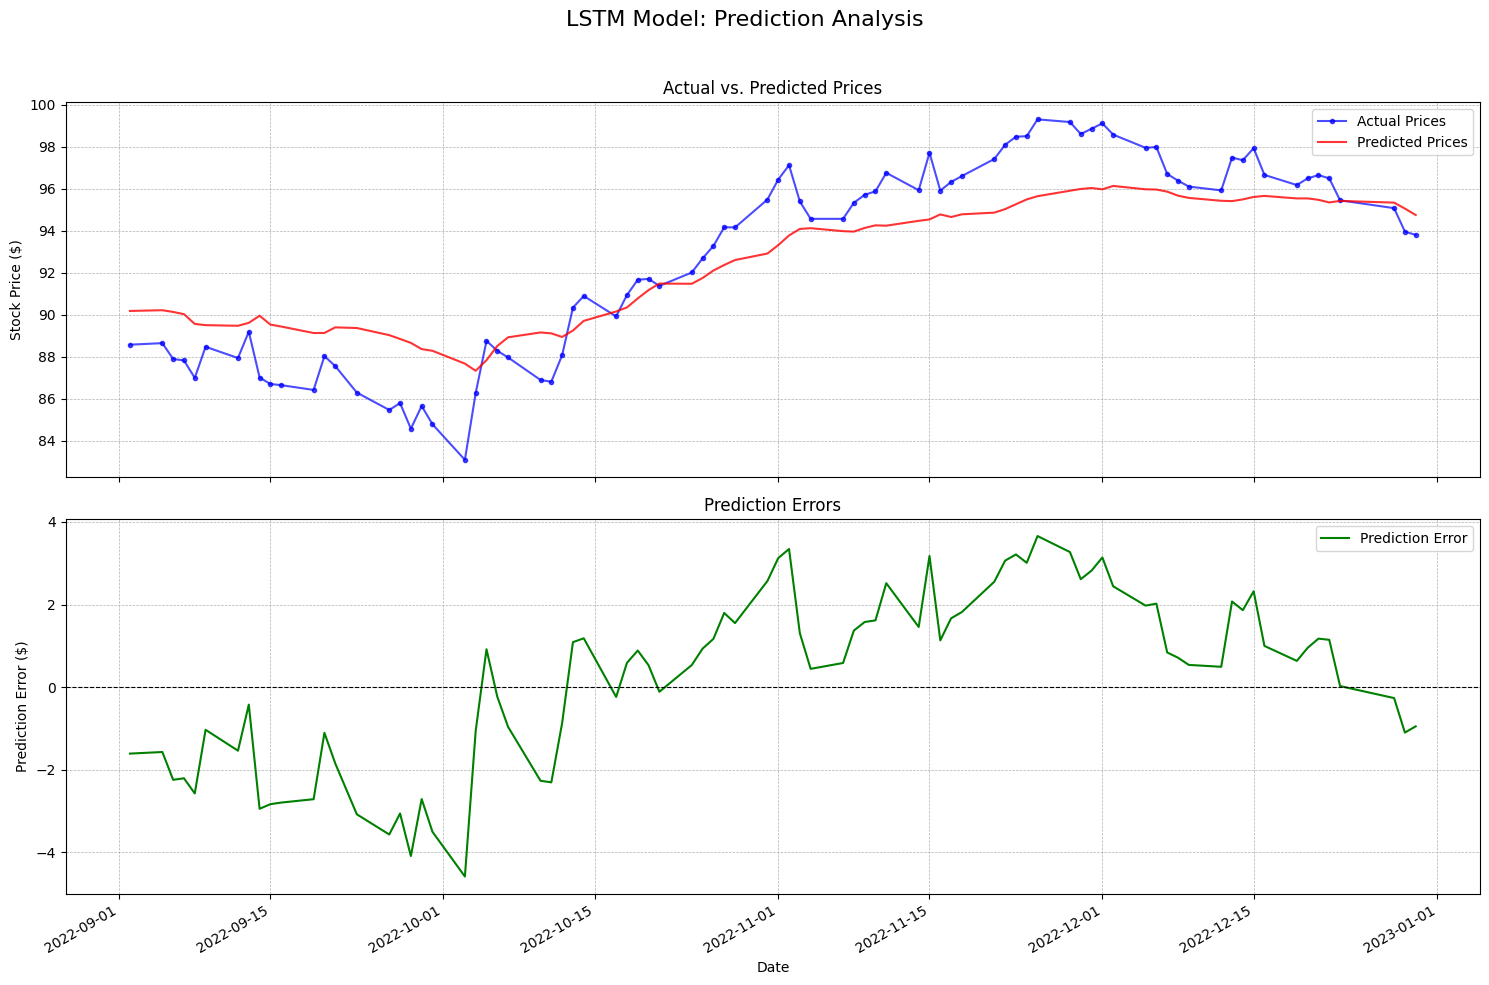


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
707 2022-12-23         95.46        95.430000   0.03            0.03
662 2022-10-21         91.38        91.489998  -0.11            0.11
651 2022-10-06         88.29        88.519997  -0.23            0.23
658 2022-10-17         89.93        90.160004  -0.23            0.23
708 2022-12-28         95.08        95.339996  -0.26            0.26

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10        87.680000  -4.58            4.58
645 2022-09-28         84.58        88.669998  -4.09            4.09
687 2022-11-25         99.31        95.650002   3.66            3.66
643 2022-09-26         85.47        89.029999  -3.56            3.56
647 2022-09-30         84.79        88.290001  -3.50            3.50

--- Statistical Summary of Error

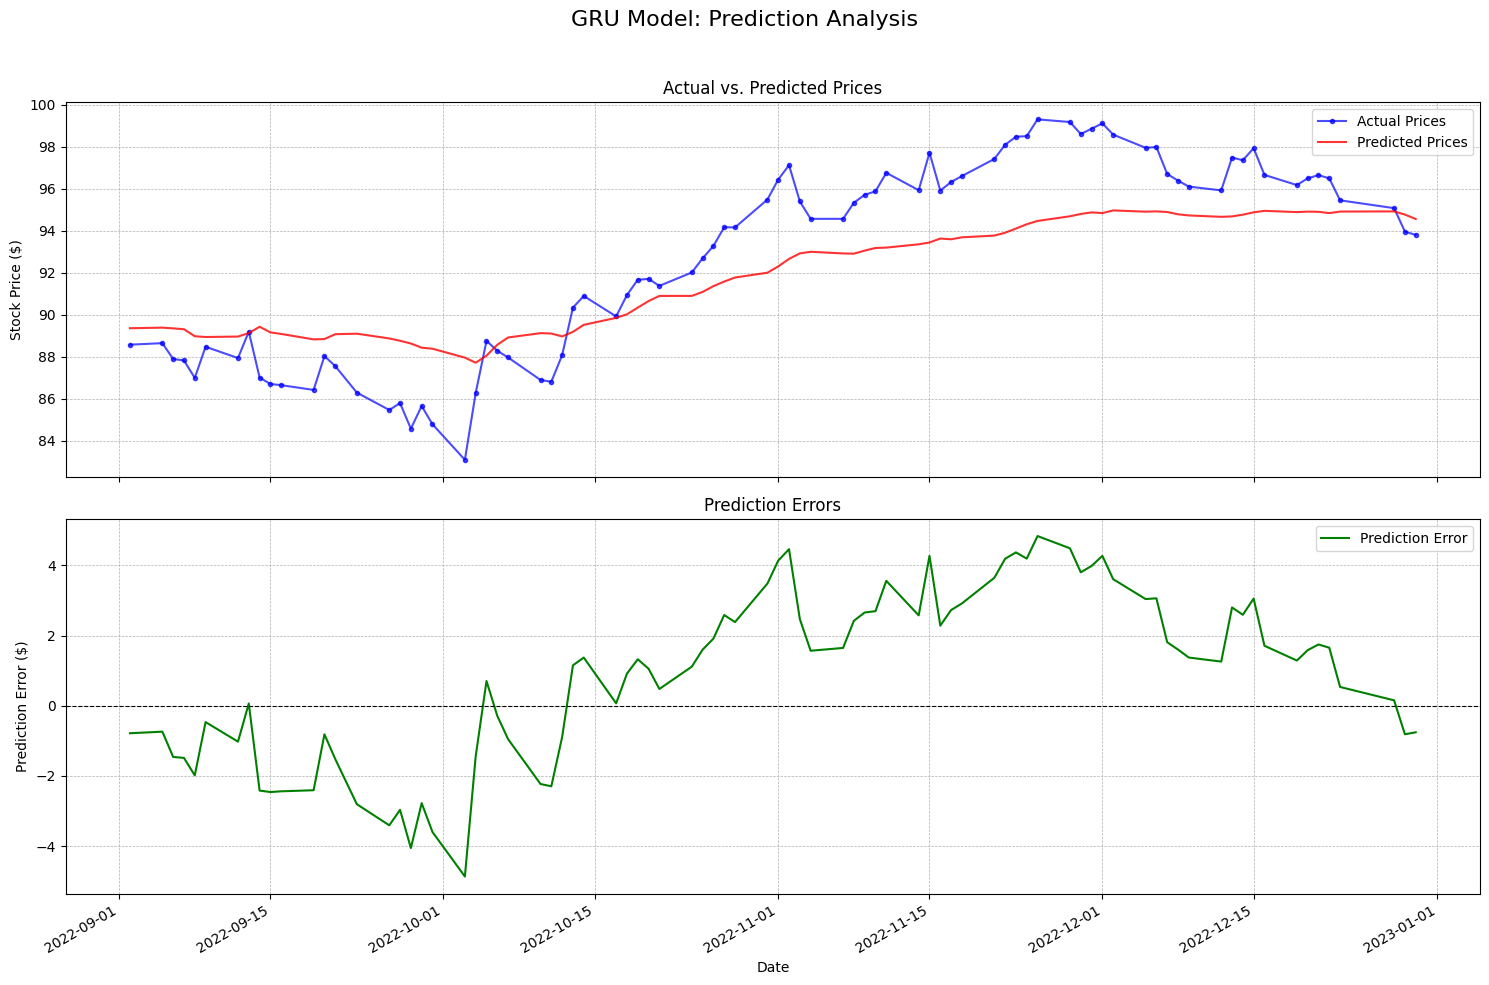


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
635 2022-09-13         89.20        89.129997   0.07            0.07
658 2022-10-17         89.93        89.860001   0.07            0.07
708 2022-12-28         95.08        94.930000   0.15            0.15
651 2022-10-06         88.29        88.580002  -0.29            0.29
633 2022-09-09         88.48        88.949997  -0.47            0.47

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10        87.959999  -4.87            4.87
687 2022-11-25         99.31        94.470001   4.84            4.84
688 2022-11-28         99.18        94.690002   4.49            4.49
670 2022-11-02         97.13        92.660004   4.46            4.46
685 2022-11-23         98.48        94.110001   4.37            4.37

--- Statistical Summary of Error

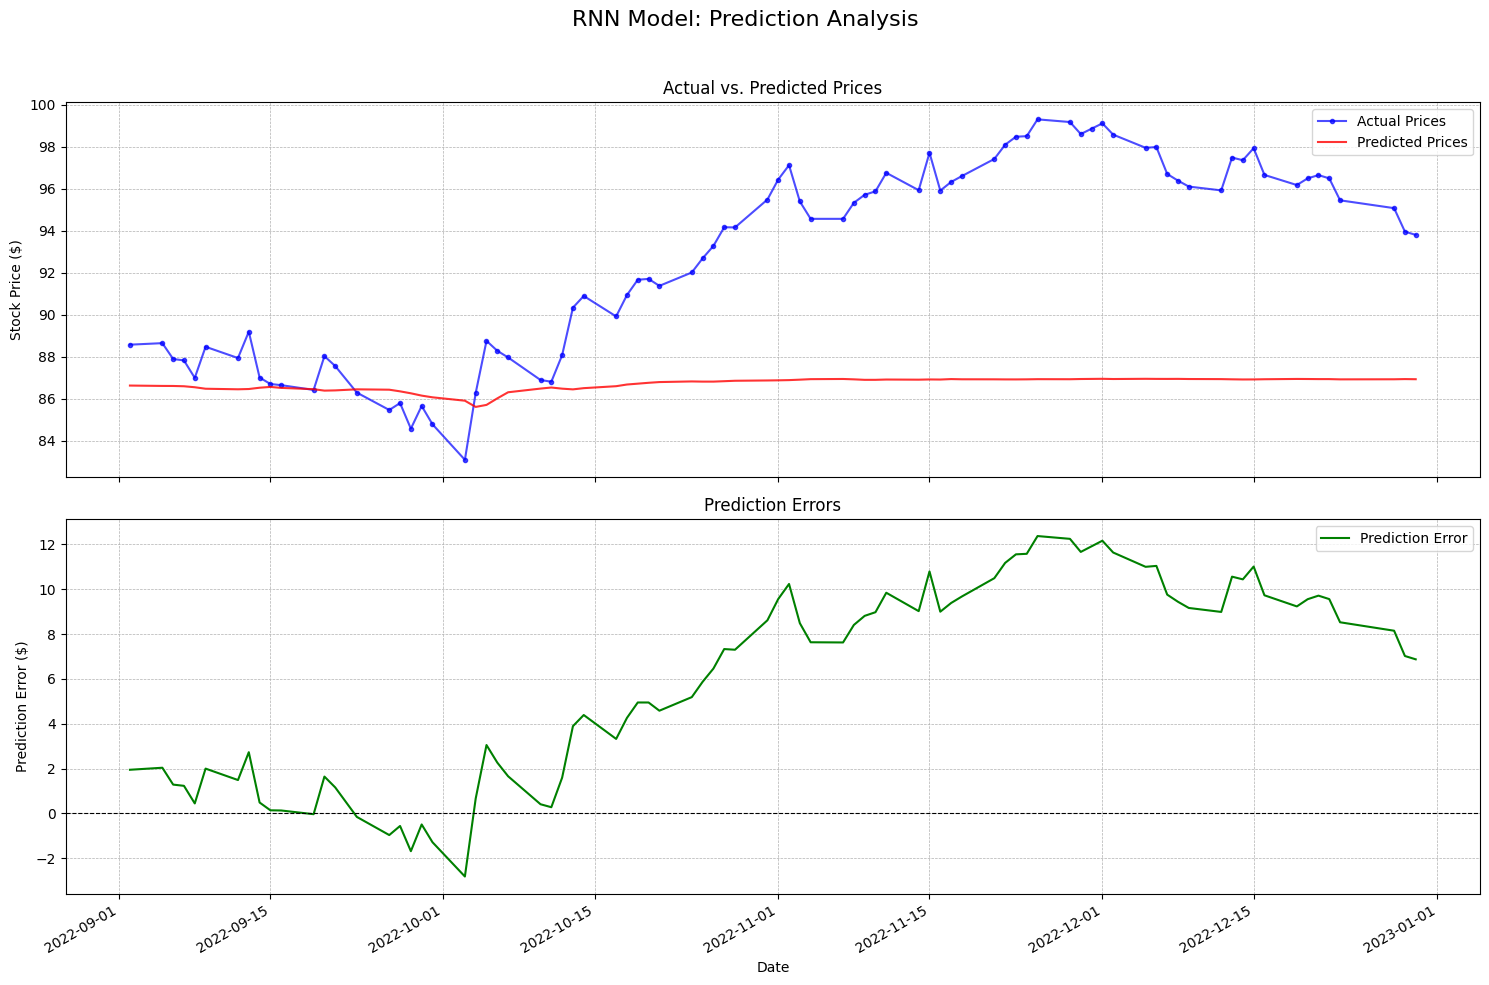


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
639 2022-09-19         86.42        86.459999  -0.04            0.04
638 2022-09-16         86.65        86.519997   0.13            0.13
637 2022-09-15         86.71        86.570000   0.14            0.14
642 2022-09-23         86.30        86.449997  -0.16            0.16
654 2022-10-11         86.82        86.540001   0.28            0.28

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
687 2022-11-25         99.31        86.940002  12.37           12.37
688 2022-11-28         99.18        86.930000  12.25           12.25
691 2022-12-01         99.12        86.949997  12.17           12.17
690 2022-11-30         98.87        86.949997  11.92           11.92
689 2022-11-29         98.61        86.940002  11.67           11.67

--- Statistical Summary of Error

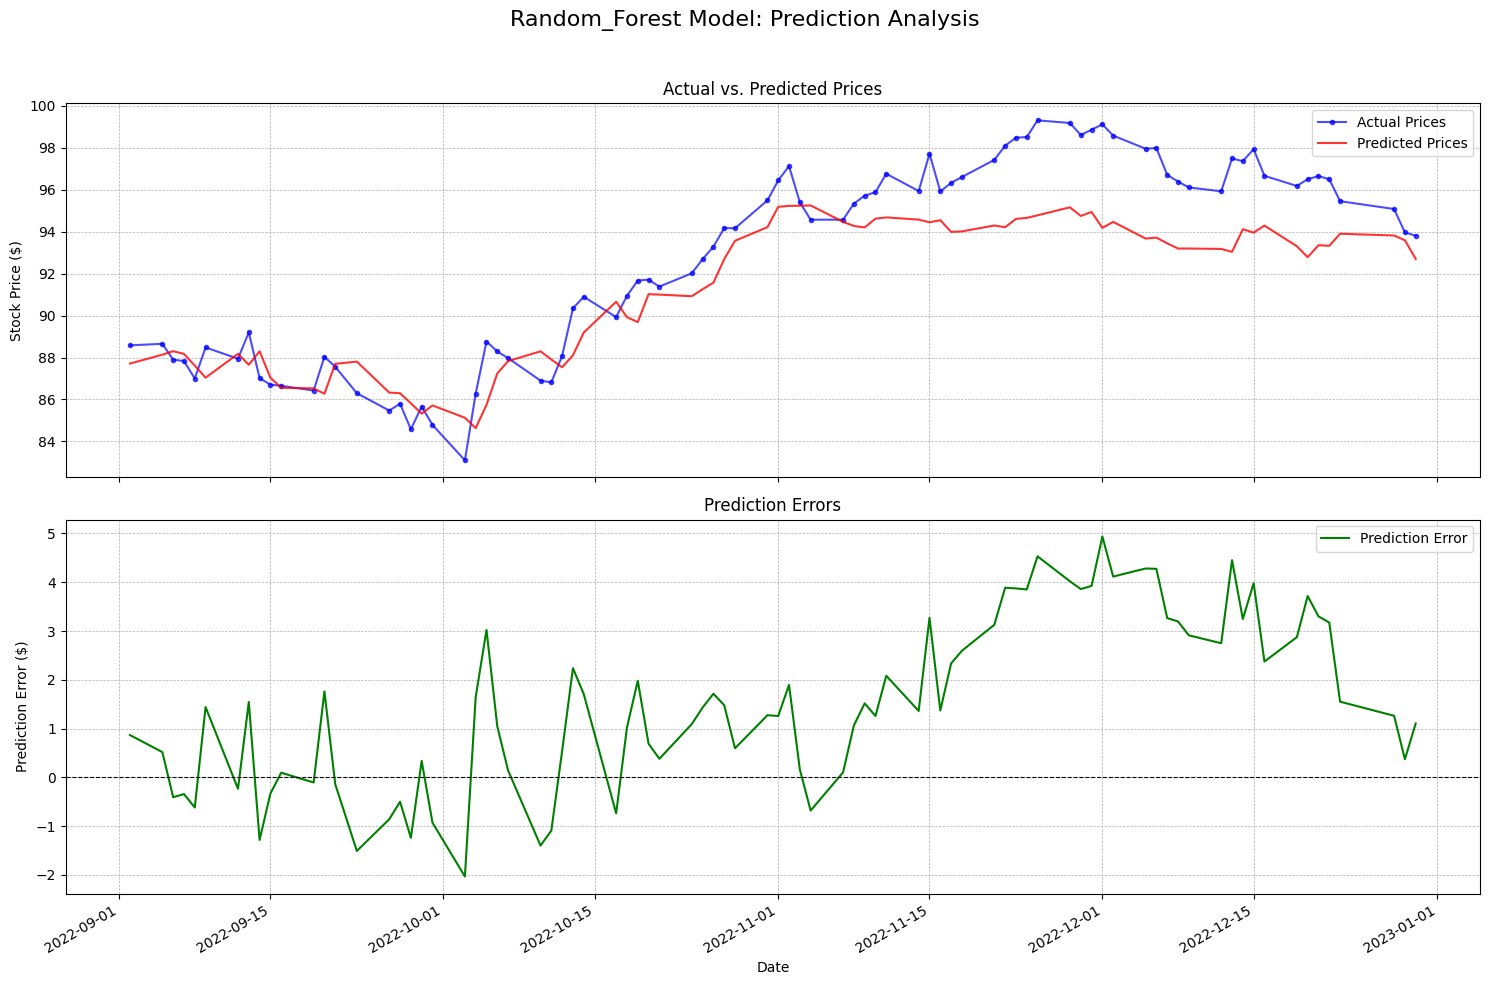


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
638 2022-09-16         86.65            86.56   0.10            0.10
673 2022-11-07         94.57            94.47   0.10            0.10
639 2022-09-19         86.42            86.53  -0.10            0.10
641 2022-09-21         87.56            87.70  -0.14            0.14
652 2022-10-07         87.97            87.83   0.14            0.14

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
691 2022-12-01         99.12            94.18   4.94            4.94
687 2022-11-25         99.31            94.78   4.53            4.53
699 2022-12-13         97.49            93.04   4.45            4.45
693 2022-12-05         97.96            93.67   4.28            4.28
694 2022-12-06         97.99            93.72   4.27            4.27

--- Statistical Summary of Error

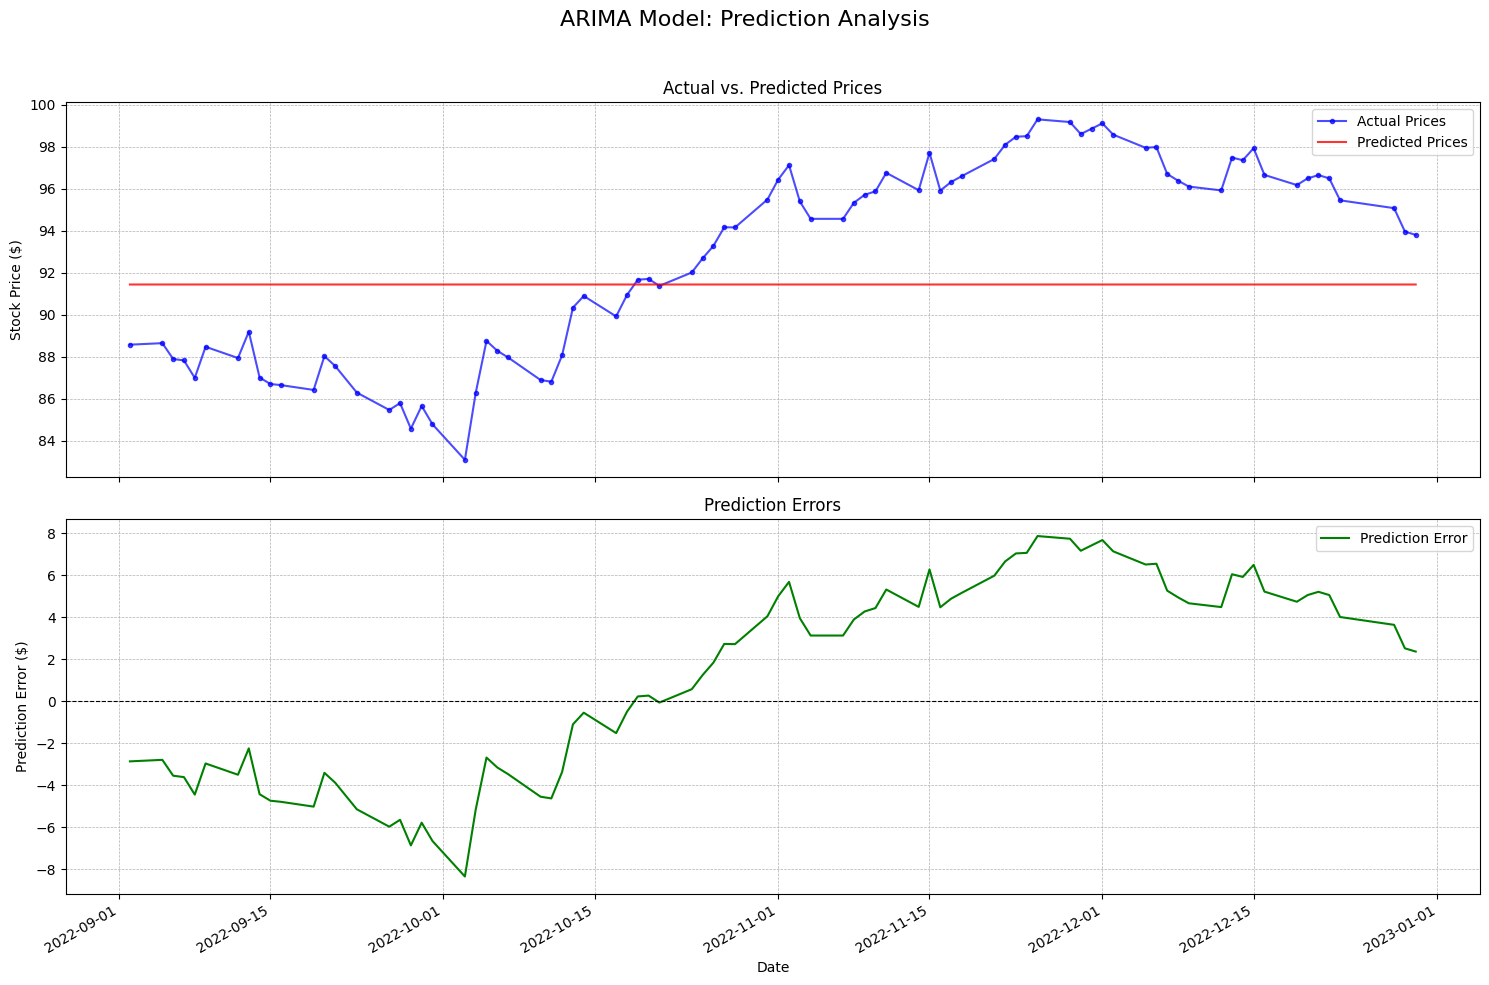


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
662 2022-10-21         91.38            91.45  -0.06            0.06
660 2022-10-19         91.67            91.45   0.23            0.23
661 2022-10-20         91.71            91.45   0.27            0.27
659 2022-10-18         90.94            91.45  -0.50            0.50
657 2022-10-14         90.90            91.45  -0.55            0.55

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10            91.45  -8.35            8.35
687 2022-11-25         99.31            91.45   7.87            7.87
688 2022-11-28         99.18            91.45   7.74            7.74
691 2022-12-01         99.12            91.45   7.67            7.67
690 2022-11-30         98.87            91.45   7.42            7.42

--- Statistical Summary of Error

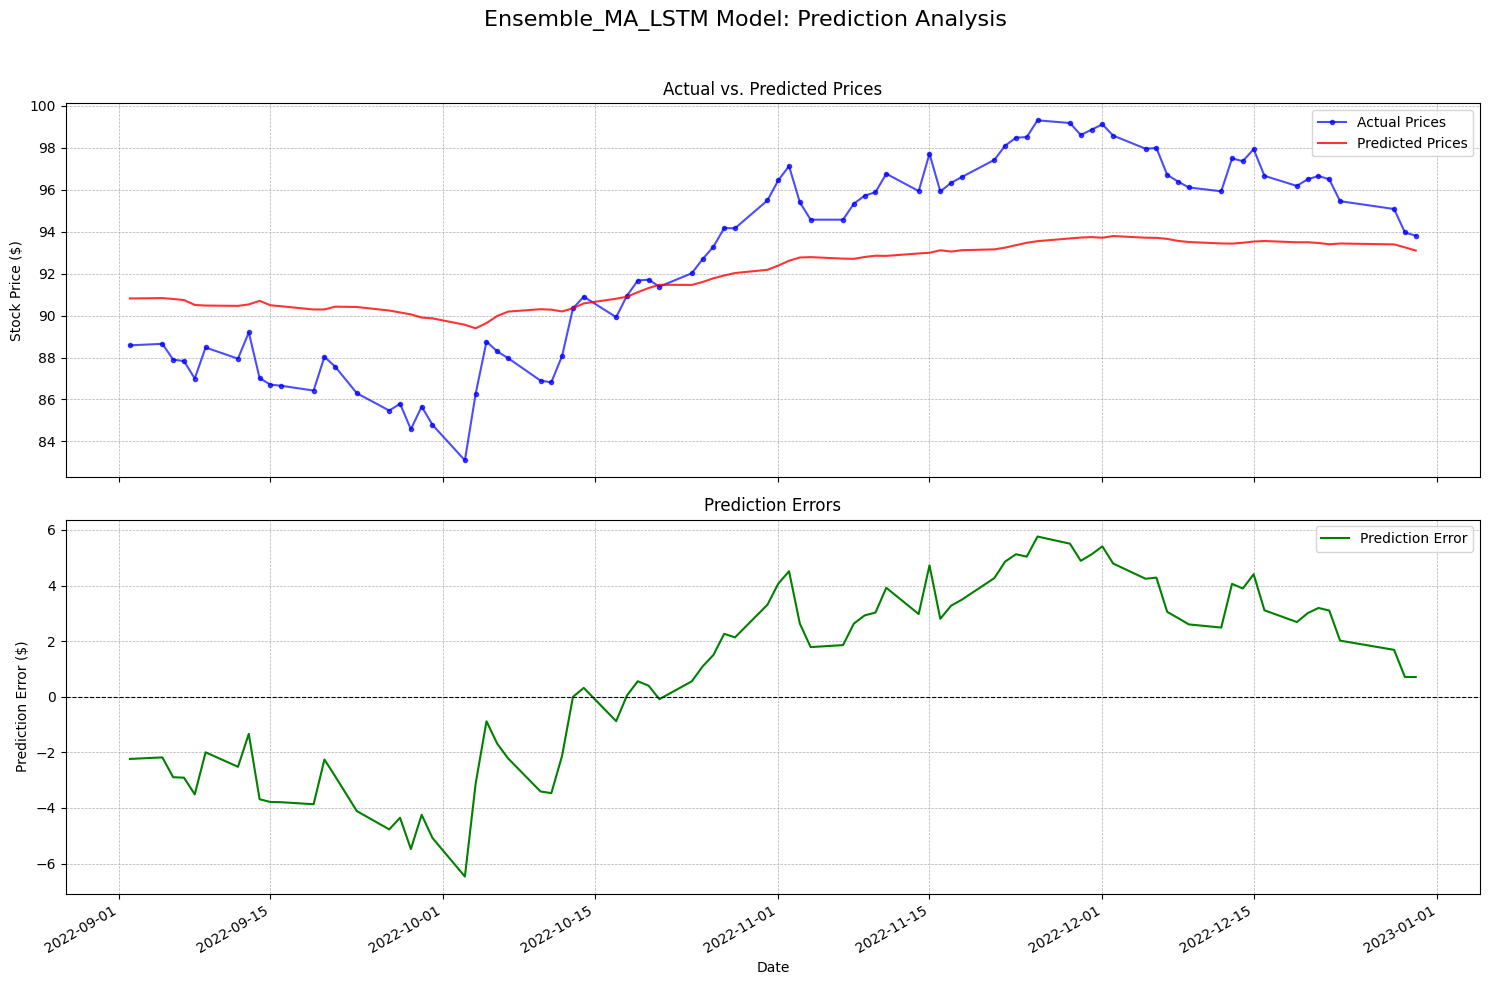


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
656 2022-10-13         90.34            90.35  -0.01            0.01
659 2022-10-18         90.94            90.90   0.04            0.04
662 2022-10-21         91.38            91.47  -0.09            0.09
657 2022-10-14         90.90            90.58   0.32            0.32
661 2022-10-20         91.71            91.31   0.40            0.40

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10            89.56  -6.47            6.47
687 2022-11-25         99.31            93.55   5.76            5.76
688 2022-11-28         99.18            93.68   5.51            5.51
645 2022-09-28         84.58            90.06  -5.48            5.48
691 2022-12-01         99.12            93.71   5.41            5.41

--- Statistical Summary of Error

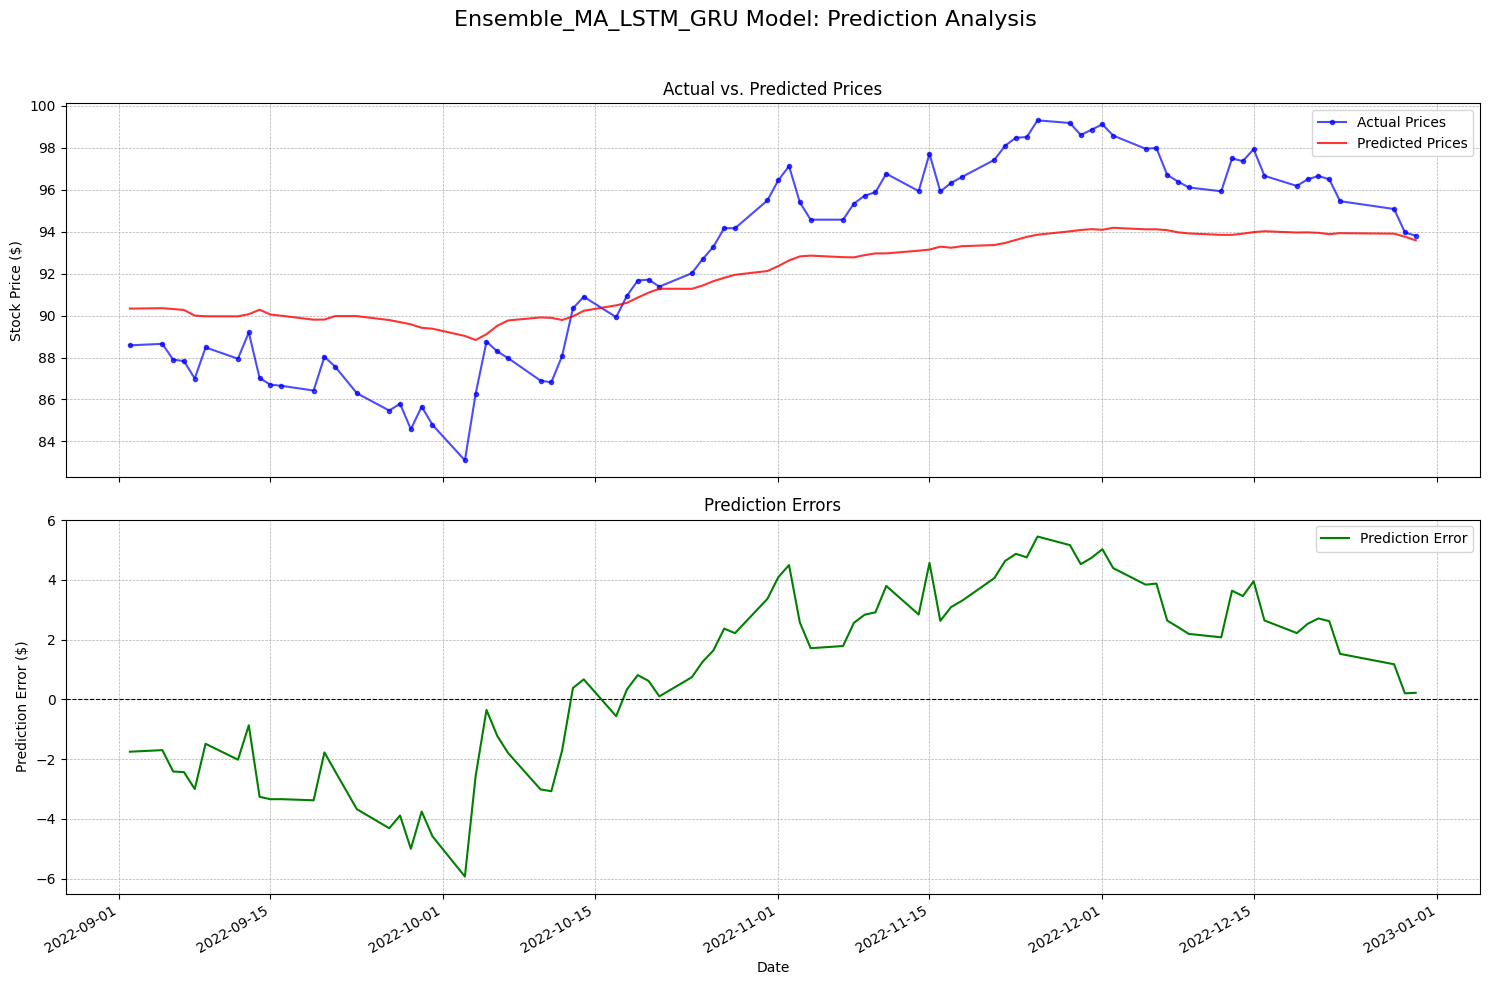


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
662 2022-10-21         91.38            91.28   0.10            0.10
709 2022-12-29         93.96            93.76   0.20            0.20
710 2022-12-30         93.81            93.59   0.22            0.22
659 2022-10-18         90.94            90.61   0.34            0.34
650 2022-10-05         88.76            89.11  -0.35            0.35

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
648 2022-10-03         83.10            89.03  -5.93            5.93
687 2022-11-25         99.31            93.86   5.45            5.45
688 2022-11-28         99.18            94.02   5.17            5.17
691 2022-12-01         99.12            94.09   5.03            5.03
645 2022-09-28         84.58            89.58  -5.00            5.00

--- Statistical Summary of Error

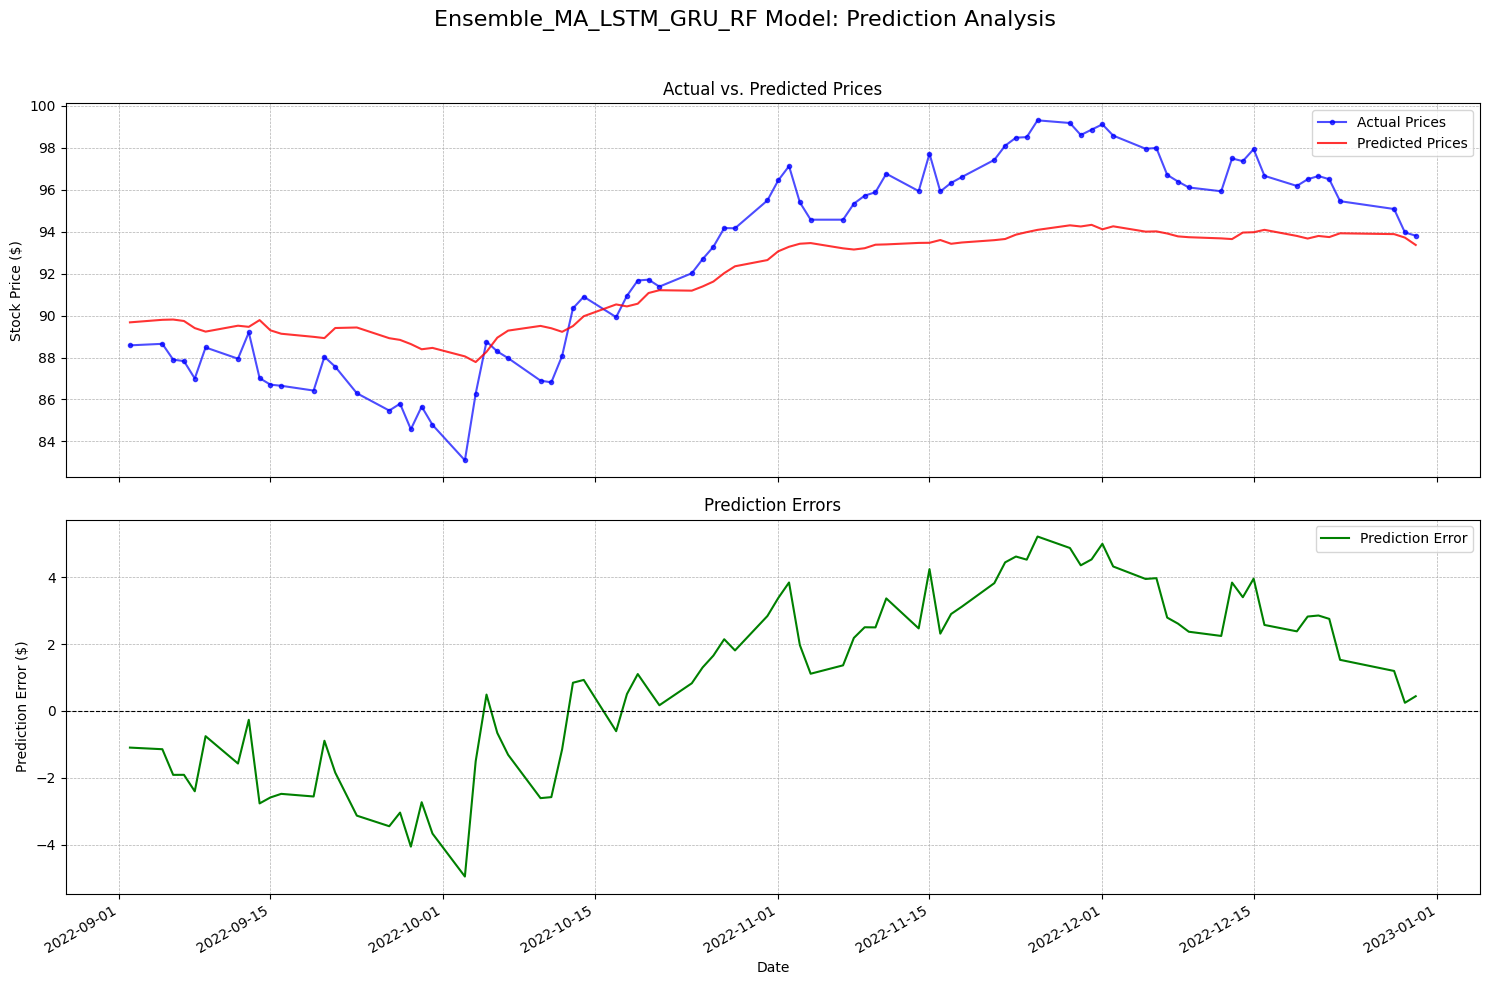


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
662 2022-10-21         91.38            91.21   0.17            0.17
709 2022-12-29         93.96            93.72   0.25            0.25
635 2022-09-13         89.20            89.46  -0.26            0.26
710 2022-12-30         93.81            93.37   0.44            0.44
650 2022-10-05         88.76            88.27   0.49            0.49

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
687 2022-11-25         99.31            94.09   5.22            5.22
691 2022-12-01         99.12            94.11   5.01            5.01
648 2022-10-03         83.10            88.05  -4.96            4.96
688 2022-11-28         99.18            94.30   4.88            4.88
685 2022-11-23         98.48            93.86   4.62            4.62

--- Statistical Summary of Error

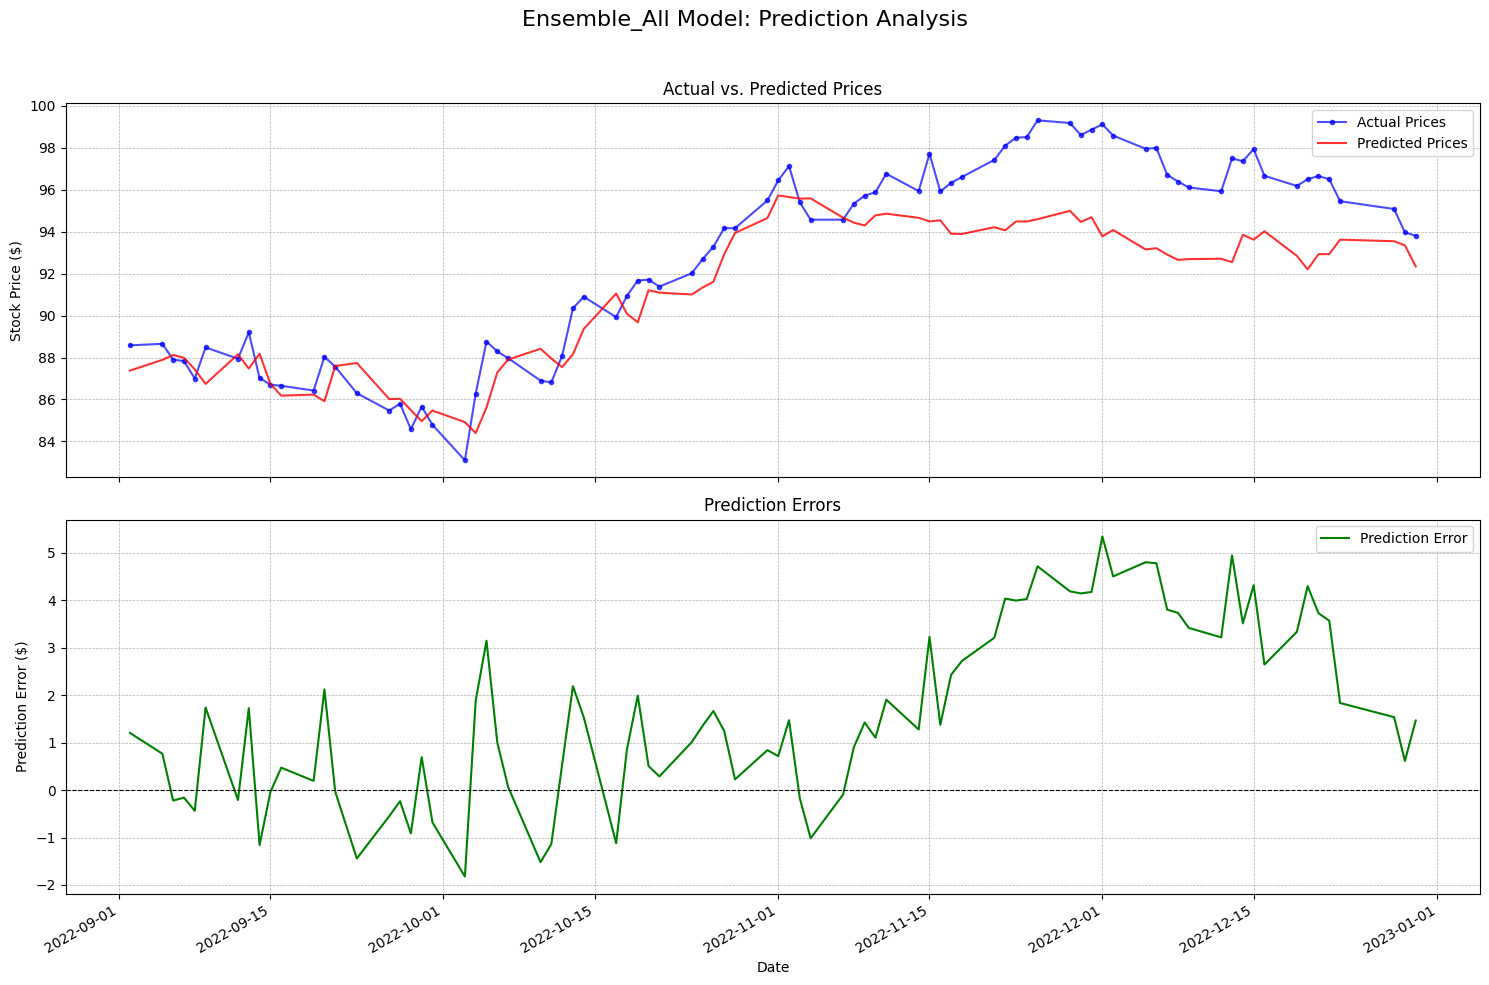


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
641 2022-09-21         87.56            87.60  -0.04            0.04
637 2022-09-15         86.71            86.75  -0.04            0.04
652 2022-10-07         87.97            87.90   0.07            0.07
673 2022-11-07         94.57            94.67  -0.10            0.10
631 2022-09-07         87.83            87.99  -0.16            0.16

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
691 2022-12-01         99.12            93.78   5.34            5.34
699 2022-12-13         97.49            92.55   4.95            4.95
693 2022-12-05         97.96            93.15   4.80            4.80
694 2022-12-06         97.99            93.21   4.78            4.78
687 2022-11-25         99.31            94.60   4.72            4.72

--- Statistical Summary of Error

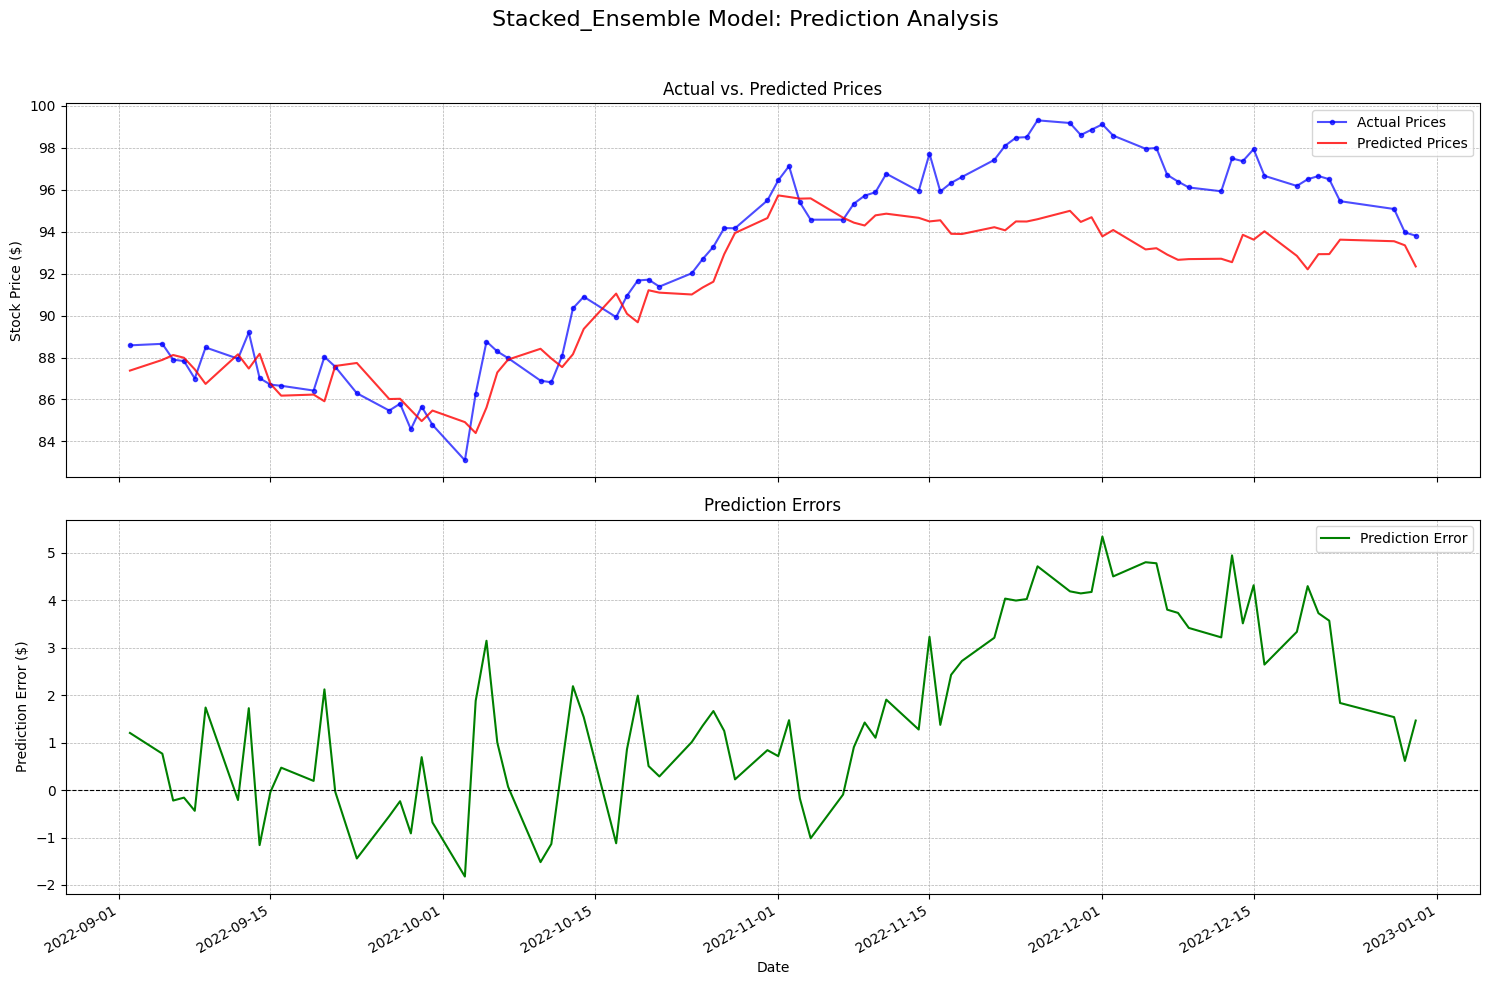


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
641 2022-09-21         87.56            87.60  -0.04            0.04
637 2022-09-15         86.71            86.75  -0.04            0.04
652 2022-10-07         87.97            87.90   0.07            0.07
673 2022-11-07         94.57            94.67  -0.10            0.10
631 2022-09-07         87.83            87.99  -0.16            0.16

❌ 5 Worst Predictions (Highest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
691 2022-12-01         99.12            93.78   5.34            5.34
699 2022-12-13         97.49            92.55   4.95            4.95
693 2022-12-05         97.96            93.15   4.80            4.80
694 2022-12-06         97.99            93.21   4.78            4.78
687 2022-11-25         99.31            94.60   4.72            4.72

--- Statistical Summary of Error

In [24]:
# Model Evaluation and Visualization
# --- Prepare Data for Evaluation ---
# Extract the actual prices and dates from the dataframe
actual_prices = predictions_viz_data['Actual']
prediction_dates = predictions_viz_data['Date']

# Get a list of all model prediction columns to iterate over
model_columns = [col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]

# --- Calculate and Display Overall Metrics ---
metrics = []
for model_name in model_columns:
    pred_prices = predictions_viz_data[model_name]
    mae = mean_absolute_error(actual_prices, pred_prices)
    mse = mean_squared_error(actual_prices, pred_prices)
    rmse = np.sqrt(mse)
    metrics.append({'Model': model_name, 'MAE ($)': mae, 'MSE': mse, 'RMSE ($)': rmse})

metrics_df = pd.DataFrame(metrics).set_index('Model')
print("\n--- Overall Prediction Performance Metrics (Sorted by MAE) ---")
print(metrics_df.sort_values('MAE ($)').round(4))
print("==============================================================")


# --- Detailed Analysis and Visualization for Each Model ---
for model_name in model_columns:
    print(f"\n--- Detailed Analysis for {model_name} Model ---")
    
    # Create a results DataFrame for the current model
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Actual_Price': actual_prices.values,
        'Predicted_Price': predictions_viz_data[model_name].values
    })
    results_df['Error'] = results_df['Actual_Price'] - results_df['Predicted_Price']
    results_df['Absolute_Error'] = np.abs(results_df['Error'])
    
    # Save this model's predictions to a CSV file
    predictions_filename = os.path.join(DATA_DIR, f"{COMPANY}_predictions_{model_name}.csv")
    results_df.to_csv(predictions_filename, index=False)
    print(f"✅ Predictions for {model_name} saved to: {predictions_filename}")
    
    # Plot predictions vs. actuals and the prediction errors
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(f'{model_name} Model: Prediction Analysis', fontsize=16)
    
    ax1.plot(results_df['Date'], results_df['Actual_Price'], label='Actual Prices', color='blue', linestyle='-', marker='.', alpha=0.7)
    ax1.plot(results_df['Date'], results_df['Predicted_Price'], label='Predicted Prices', color='red', linestyle='-', alpha=0.8)
    ax1.set_ylabel('Stock Price ($)')
    ax1.set_title('Actual vs. Predicted Prices')
    ax1.legend()
    ax1.grid(True, linestyle='--', linewidth=0.5)
    
    ax2.plot(results_df['Date'], results_df['Error'], label='Prediction Error', color='green', linestyle='-')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Prediction Error ($)')
    ax2.set_title('Prediction Errors')
    ax2.legend()
    ax2.grid(True, linestyle='--', linewidth=0.5)
    
    # Improve date formatting on the x-axis
    fig.autofmt_xdate()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Show the best and worst predictions for this model
    print("\n--- Prediction Highlights & Lowlights ---")
    print("\n✅ 5 Best Predictions (Lowest Absolute Error):")
    print(results_df.sort_values('Absolute_Error').head(5).round(2))
    print("\n❌ 5 Worst Predictions (Highest Absolute Error):")
    print(results_df.sort_values('Absolute_Error', ascending=False).head(5).round(2))
    
    print("\n--- Statistical Summary of Errors ---")
    print(results_df['Error'].describe().round(4))

In [25]:
# Interactive Candlestick Visualization

# --- Prerequisite Check ---
try:
    predictions_viz_data
    print("✅ Found 'predictions_viz_data' DataFrame. Ready for visualization.")
except NameError:
    print("❌ CRITICAL ERROR: 'predictions_viz_data' DataFrame not found.")
    print("   Please ensure the 'Ensemble Modeling' and 'Improved Stacked Ensemble Modeling' cells have been run successfully.")
    raise

# --- Visualization Functions (no changes needed) ---
def create_candlestick_data(df, n_days=1):
    """Aggregate daily data into N-day candlesticks."""
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    if n_days == 1:
        return df
    grouped = df.groupby(np.arange(len(df)) // n_days).agg(
        Date=('Date', 'first'),
        Open=('Open', 'first'),
        High=('High', 'max'),
        Low=('Low', 'min'),
        Close=('Close', 'last'),
        Volume=('Volume', 'sum'),
        Actual_Price=('Actual_Price', 'last'),
        Predicted_Price=('Predicted_Price', 'last'),
    )
    return grouped

def plot_prediction_candlesticks(df, title, n_days, limit_days):
    """Create a candlestick chart with predictions overlay."""
    plot_data = df.copy()
    if limit_days:
        plot_data = plot_data.tail(limit_days)
    plot_data = create_candlestick_data(plot_data, n_days=n_days)
    
    if plot_data.empty:
        print("No data available to plot.")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(title, fontsize=16)
    plot_data['Date_Num'] = mdates.date2num(pd.to_datetime(plot_data['Date']))
    width = 0.8 * n_days
    
    for index, row in plot_data.iterrows():
        color = 'green' if row['Close'] >= row['Open'] else 'red'
        ax1.plot([row['Date_Num'], row['Date_Num']], [row['Low'], row['High']], color='black', linewidth=1)
        body = Rectangle((row['Date_Num'] - width/2, min(row['Open'], row['Close'])), width, abs(row['Close'] - row['Open']), facecolor=color, edgecolor='black')
        ax1.add_patch(body)
    
    ax1.plot(plot_data['Date_Num'], plot_data['Actual_Price'], label='Actual Price', color='blue', linestyle='--', alpha=0.9, linewidth=2)
    ax1.plot(plot_data['Date_Num'], plot_data['Predicted_Price'], label='Predicted Price', color='orange', linestyle='-', alpha=0.9, linewidth=2)
    ax1.set_ylabel('Price ($)')
    ax1.set_title('Actual vs. Predicted Prices')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    volume_colors = ['green' if row['Close'] >= row['Open'] else 'red' for _, row in plot_data.iterrows()]
    ax2.bar(plot_data['Date_Num'], plot_data['Volume'], width=width, color=volume_colors, alpha=0.6)
    ax2.set_ylabel('Volume')
    ax2.set_title('Volume')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Interactive Loop ---
# Get the list of all available models for visualization
available_models = [col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]
model_map = {str(i + 1): model for i, model in enumerate(available_models)}

while True:
    print("\n--- Interactive Candlestick Visualization ---")
    # Dynamically create the menu of all available models
    for key, model_name in model_map.items():
        print(f"{key}: {model_name}")
    print("q: Quit")
    
    choice = input(f"Enter your choice (1-{len(model_map)}/q): ").strip().lower()
    
    if choice == 'q':
        print("Exiting visualization.")
        break
    
    if choice not in model_map:
        print("❌ Invalid choice. Please select a number from the list.")
        continue
    
    model_name = model_map[choice]
    
    try:
        n_days_input = input("Enter number of days per candlestick (default: 1): ").strip()
        n_days = int(n_days_input) if n_days_input else 1
        
        limit_days_input = input("Enter number of recent days to display (default: 90): ").strip()
        limit_days = int(limit_days_input) if limit_days_input else 90
    except ValueError:
        print("❌ Invalid number. Using defaults.")
        n_days, limit_days = 1, 90
    
    try:
        # --- Prepare DataFrame for Plotting ---
        # Merge OHLCV data from `test_data` with predictions from `predictions_viz_data`.
        
        pred_subset = predictions_viz_data[['Date', 'Actual', model_name]].copy()
        
        # The original data uses 'Price' for the open price. Rename it to 'Open' for the plot.
        if 'Open' not in test_data.columns and 'Price' in test_data.columns:
             test_data_plot = test_data.rename(columns={'Price': 'Open'})
        else:
             test_data_plot = test_data.copy()

        # Merge on 'Date' to ensure data is perfectly aligned
        plot_df = pd.merge(test_data_plot, pred_subset, on='Date', how='inner')
        
        # Rename columns to what the plotting function expects
        plot_df = plot_df.rename(columns={'Actual': 'Actual_Price', model_name: 'Predicted_Price'})
        
        # Call the plotting function
        plot_prediction_candlesticks(
            plot_df, 
            f"{COMPANY} - {model_name} Model Predictions", 
            n_days, 
            limit_days
        )
    except Exception as e:
        print(f"❌ An unexpected error occurred while preparing the plot:")

✅ Found 'predictions_viz_data' DataFrame. Ready for visualization.

--- Interactive Candlestick Visualization ---
1: LSTM
2: GRU
3: RNN
4: Random_Forest
5: ARIMA
6: Ensemble_MA_LSTM
7: Ensemble_MA_LSTM_GRU
8: Ensemble_MA_LSTM_GRU_RF
9: Ensemble_All
10: Stacked_Ensemble
q: Quit
Exiting visualization.


In [26]:
# Boxplot Analysis
# --- Visualization Functions (no changes needed) ---
def create_boxplot_data(df, period='monthly'):
    """Prepare data for boxplot visualization."""
    df_copy = df.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    
    if period == 'monthly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-%m')
    elif period == 'quarterly':
        df_copy['Period'] = df_copy['Date'].dt.to_period('Q').astype(str)
    elif period == 'yearly':
        df_copy['Period'] = df_copy['Date'].dt.year.astype(str)
    elif period == 'weekly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-W%U')
    else:
        raise ValueError("Period must be one of 'monthly', 'quarterly', 'yearly', or 'weekly'")
    
    df_copy['Price_Range'] = df_copy['High'] - df_copy['Low']
    df_copy['Daily_Return'] = df_copy['Close'].pct_change() * 100
    return df_copy

def plot_price_boxplots(df, period='monthly'):
    """Create boxplots for historical stock data."""
    boxplot_data = create_boxplot_data(df, period)
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f'Historical Stock Analysis by {period.title()}', fontsize=16)
    
    sns.boxplot(ax=axes[0, 0], data=boxplot_data, x='Period', y='Close', palette='viridis')
    axes[0, 0].set_title('Close Price Distribution')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(ax=axes[0, 1], data=boxplot_data, x='Period', y='Price_Range', palette='plasma')
    axes[0, 1].set_title('Daily Price Range (Volatility)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    sns.boxplot(ax=axes[1, 0], data=boxplot_data, x='Period', y='Volume', palette='magma')
    axes[1, 0].set_title('Trading Volume Distribution')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(ax=axes[1, 1], data=boxplot_data, x='Period', y='Daily_Return', palette='cividis')
    axes[1, 1].set_title('Daily Returns Distribution (%)')
    axes[1, 1].axhline(0, color='black', linestyle='--')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_prediction_error_boxplots(results_df, model_name):
    """Create boxplots for prediction errors."""
    results_df['Error'] = results_df['Actual_Price'] - results_df['Predicted_Price']
    results_df['Absolute_Error'] = np.abs(results_df['Error'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f'{model_name} Model: Prediction Error Analysis', fontsize=16)
    
    sns.boxplot(ax=ax1, y=results_df['Error'], palette='coolwarm')
    ax1.axhline(0, color='black', linestyle='--')
    ax1.set_title('Prediction Error')
    ax1.set_ylabel('Error ($)')
    
    sns.boxplot(ax=ax2, y=results_df['Absolute_Error'], palette='spring')
    ax2.set_title('Absolute Prediction Error')
    ax2.set_ylabel('Absolute Error ($)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Interactive Loop ---
while True:
    print("\n--- Boxplot Analysis Menu ---")
    print("1: Historical Data Analysis")
    print("2: Prediction Error Analysis")
    print("q: Quit")
    choice = input("Enter your choice (1/2/q): ").strip().lower()
    
    if choice == 'q':
        print("Exiting boxplot analysis.")
        break
    
    try:
        if choice == '1':
            print("\nSelect period for historical analysis:")
            print("1: Monthly\n2: Quarterly\n3: Yearly\n4: Weekly")
            period_choice = input("Enter choice [default: 1]: ").strip()
            period_map = {'1': 'monthly', '2': 'quarterly', '3': 'yearly', '4': 'weekly'}
            period = period_map.get(period_choice, 'monthly')
            
            # Concatenate train and test data to get the full historical range
            full_historical_df = pd.concat([train_data, test_data], ignore_index=True)
            plot_price_boxplots(full_historical_df, period=period)
        
        elif choice == '2':
            # Dynamically get all available models for error analysis
            available_models = [col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]
            model_map = {str(i + 1): model for i, model in enumerate(available_models)}
            
            print("\nSelect a model for prediction error analysis:")
            for key, model_name in model_map.items():
                print(f"{key}: {model_name}")
            
            model_choice = input(f"Enter choice (1-{len(model_map)}): ").strip()
            
            if model_choice not in model_map:
                print("❌ Invalid model choice.")
                continue
                
            model_name = model_map[model_choice]
            
            # Create the dataframe for the selected model from the master visualization data
            prediction_df = predictions_viz_data[['Actual', model_name]].copy()
            prediction_df.rename(columns={'Actual': 'Actual_Price', model_name: 'Predicted_Price'}, inplace=True)
            
            plot_prediction_error_boxplots(prediction_df, model_name)
        
        else:
            print("❌ Invalid choice. Please enter 1, 2, or q.")
            
    except Exception as e:
        print(f"❌ An error occurred: {e}")


--- Boxplot Analysis Menu ---
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit
Exiting boxplot analysis.


In [27]:
# Multistep Prediction Functions
def solve_multivariate_multistep_prediction(model, last_sequence, k, scalers, feature_order):
    """Predict k days into the future using multivariate input."""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(k):
        next_close_scaled = model.predict(current_sequence.reshape(1, PREDICTION_DAYS, -1), verbose=0)[0, 0]
        predictions.append(scalers['Close'].inverse_transform([[next_close_scaled]])[0, 0])
        
        new_step = current_sequence[0, -1, :].copy()
        close_feature_index = feature_order.index('Close')
        new_step[close_feature_index] = next_close_scaled
        new_step = new_step.reshape(1, 1, current_sequence.shape[2])
        current_sequence = np.append(current_sequence[:, 1:, :], new_step, axis=1)
    
    return predictions

In [28]:
# Advanced Future Predictions
# --- Prerequisite Checks ---
try:
    # Check for all necessary models and variables
    all_models_performance
    lstm_model
    gru_model
    rnn_model
    rf_model
    fitted_arima
    meta_learner
    weights
    scalers
    test_values
    feature_columns
    PREDICTION_DAYS
    create_rf_features
    print("✅ All prerequisite models and variables found. Ready for future prediction.")
except NameError as e:
    print(f"❌ CRITICAL ERROR: A required variable or model is missing: {e}")
    print("   Please ensure all preceding cells, especially model training and ensemble creation, have been run successfully.")
    raise

# --- Unified Future Prediction Function ---
def generate_future_predictions(model_name, future_days, last_sequence, all_models, scalers, feature_columns):
    """
    Generates future predictions for a specified model.
    Handles individual, ensemble, and stacked models recursively.
    """
    # Unpack all models from the dictionary
    lstm_m = all_models.get('LSTM')
    gru_m = all_models.get('GRU')
    rnn_m = all_models.get('RNN')
    rf_m = all_models.get('Random_Forest')
    arima_m = all_models.get('ARIMA')
    meta_m = all_models.get('Stacked_Ensemble_Meta')
    weights_dict = all_models.get('Weighted_Ensemble_Weights')

    # --- Pre-calculate ARIMA forecast ---
    # ARIMA is not recursive in the same way as NNs. We forecast all future steps at once for efficiency and accuracy.
    arima_preds_unscaled = arima_m.forecast(steps=future_days)
    arima_preds_scaled = scalers['Close'].transform(arima_preds_unscaled.values.reshape(-1, 1)).flatten()

    # If the chosen model is just ARIMA, we can return the direct forecast.
    if model_name == 'ARIMA':
        print("✅ Using direct ARIMA forecast for all future days.")
        return arima_preds_unscaled.values

    # --- Recursive Prediction for all other models ---
    future_preds_unscaled = []
    current_sequence = last_sequence.copy()
    close_idx = feature_columns.index('Close') # Assuming 'Close' is the first feature

    print(f"Starting recursive prediction for '{model_name}'...")
    for i in range(future_days):
        # 1. Get predictions from all base models for the current step
        base_preds_scaled = {}
        nn_input_seq = current_sequence.reshape(1, PREDICTION_DAYS, len(feature_columns))
        
        base_preds_scaled['LSTM'] = lstm_m.predict(nn_input_seq, verbose=0)[0, 0]
        base_preds_scaled['GRU'] = gru_m.predict(nn_input_seq, verbose=0)[0, 0]
        base_preds_scaled['RNN'] = rnn_m.predict(nn_input_seq, verbose=0)[0, 0]
        
        # For RF, we must re-create the features from the sequence
        rf_features, _ = create_rf_features(nn_input_seq, [0]) # y_data is a dummy
        base_preds_scaled['Random_Forest'] = rf_m.predict(rf_features)[0]
        
        # Use the pre-calculated ARIMA prediction for this step
        base_preds_scaled['ARIMA'] = arima_preds_scaled[i]

        # 2. Determine the final prediction for this step based on the chosen model
        final_pred_scaled = 0
        
        if model_name in ['LSTM', 'GRU', 'RNN', 'Random_Forest']:
            final_pred_scaled = base_preds_scaled[model_name]
        elif model_name == 'Ensemble_MA_LSTM':
            final_pred_scaled = (base_preds_scaled['ARIMA'] + base_preds_scaled['LSTM']) / 2.0
        elif model_name == 'Ensemble_MA_LSTM_GRU':
            final_pred_scaled = (base_preds_scaled['ARIMA'] + base_preds_scaled['LSTM'] + base_preds_scaled['GRU']) / 3.0
        elif model_name == 'Ensemble_MA_LSTM_GRU_RF':
            final_pred_scaled = (base_preds_scaled['ARIMA'] + base_preds_scaled['LSTM'] + base_preds_scaled['GRU'] + base_preds_scaled['Random_Forest']) / 4.0
        elif model_name == 'Ensemble_All':
            final_pred_scaled = np.mean([p for p in base_preds_scaled.values()])
        elif model_name == 'Weighted_Ensemble':
            final_pred_scaled = (weights_dict['LSTM'] * base_preds_scaled['LSTM'] +
                                 weights_dict['GRU'] * base_preds_scaled['GRU'] +
                                 weights_dict['RNN'] * base_preds_scaled['RNN'] +
                                 weights_dict['Moving Average'] * base_preds_scaled['ARIMA'])
        elif model_name == 'Stacked_Ensemble':
            meta_input = np.column_stack([base_preds_scaled[m] for m in ['LSTM', 'GRU', 'RNN', 'Random_Forest']])
            final_pred_scaled = meta_m.predict(meta_input)[0]
        else:
            raise ValueError(f"Unknown model for future prediction: {model_name}")

        # 3. Descale the final prediction and store it
        final_pred_unscaled = scalers['Close'].inverse_transform([[final_pred_scaled]])[0, 0]
        future_preds_unscaled.append(final_pred_unscaled)

        # 4. Update the sequence for the next iteration
        new_step = current_sequence[-1, :].copy()
        new_step[close_idx] = final_pred_scaled
        new_step = new_step.reshape(1, len(feature_columns))
        current_sequence = np.append(current_sequence[1:, :], new_step, axis=0)
        
        if (i + 1) % 10 == 0:
            print(f"  -> Generated {i + 1}/{future_days} predictions...")

    return np.array(future_preds_unscaled)

# --- Main Execution ---
# 1. Consolidate all models into a single dictionary for easy access
all_models = {
    'LSTM': lstm_model, 'GRU': gru_model, 'RNN': rnn_model,
    'Random_Forest': rf_model, 'ARIMA': fitted_arima,
    'Stacked_Ensemble_Meta': meta_learner, 'Weighted_Ensemble_Weights': weights
}

# 2. Determine the best overall model from the final ranking
best_model_name = min(all_models_performance, key=all_models_performance.get)
best_model_mae = all_models_performance[best_model_name]
print(f"🏆 Best overall model identified: '{best_model_name}' (MAE: {best_model_mae:.6f})")

# 3. Interactive loop for future prediction
while True:
    print("\n--- Future Prediction Menu ---")
    # Create a map of all available models for prediction
    available_models_list = sorted(all_models_performance.keys())
    model_map = {str(i + 1): name for i, name in enumerate(available_models_list)}
    
    print(f"d: Use default best model ({best_model_name})")
    for key, name in model_map.items():
        print(f"{key}: {name} (MAE: {all_models_performance[name]:.4f})")
    print("q: Quit")
    
    choice = input("Select a model for future prediction [d]: ").strip().lower()
    
    if choice == 'q':
        print("Exiting future prediction.")
        break
    
    chosen_model_name = best_model_name
    if choice == 'd' or choice == '':
        pass # Use default
    elif choice in model_map:
        chosen_model_name = model_map[choice]
    else:
        print("❌ Invalid choice. Please select from the list.")
        continue

    try:
        days_input = input("Enter number of future days to predict [default: 30]: ").strip()
        FUTURE_DAYS = int(days_input) if days_input else 30
        
        # Prepare the last known sequence from the test data
        last_sequence = test_values[-PREDICTION_DAYS:]
        
        # Generate the predictions
        future_predictions = generate_future_predictions(
            chosen_model_name, FUTURE_DAYS, last_sequence, all_models, scalers, feature_columns
        )
        
        # Create future dates and DataFrame
        last_date = pd.to_datetime(df['Date'].iloc[-1])
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FUTURE_DAYS)
        
        future_df = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Close': future_predictions,
            'Model': chosen_model_name
        })
        
        print(f"\n✅ Generated {FUTURE_DAYS} future predictions using '{chosen_model_name}'")
        print(f"   Future prediction range: ${future_predictions.min():.2f} to ${future_predictions.max():.2f}")
        print("\n--- First 10 Future Predictions ---")
        print(future_df.head(10).round(2))
        
        # Ask to run again or exit
        rerun = input("\nRun again with a different model? (y/n) [n]: ").strip().lower()
        if rerun != 'y':
            break
            
    except Exception as e:
        print(f"❌ An error occurred during prediction: {e}")
        import traceback
        traceback.print_exc()
        break

✅ All prerequisite models and variables found. Ready for future prediction.
🏆 Best overall model identified: 'LSTM' (MAE: 1.793248)

--- Future Prediction Menu ---
d: Use default best model (LSTM)
1: ARIMA (MAE: 4.4050)
2: Ensemble_All (MAE: 3.1020)
3: Ensemble_MA_LSTM (MAE: 3.0345)
4: Ensemble_MA_LSTM_GRU (MAE: 2.7471)
5: Ensemble_MA_LSTM_GRU_RF (MAE: 2.4583)
6: GRU (MAE: 2.2348)
7: LSTM (MAE: 1.7932)
8: RNN (MAE: 6.2634)
9: Random Forest (MAE: 1.8736)
10: Stacked_Ensemble (MAE: 1.9600)
q: Quit
Starting recursive prediction for 'LSTM'...
  -> Generated 10/30 predictions...
  -> Generated 20/30 predictions...
  -> Generated 30/30 predictions...

✅ Generated 30 future predictions using 'LSTM'
   Future prediction range: $94.15 to $94.64

--- First 10 Future Predictions ---
        Date  Predicted_Close Model
0 2022-12-31            94.64  LSTM
1 2023-01-01            94.53  LSTM
2 2023-01-02            94.45  LSTM
3 2023-01-03            94.39  LSTM
4 2023-01-04            94.35  LSTM
5

In [29]:
# --- Prerequisite Checks ---
try:
    predictions_viz_data, all_models_performance, future_df, complete_data
    chosen_model_name, best_model_name, best_mae, COMPANY, FUTURE_DAYS
    print("✅ All prerequisite data found. Generating the final dashboard...")
except NameError as e:
    print(f"❌ CRITICAL ERROR: A required variable is missing: {e}")
    print("   Please ensure all preceding cells were run successfully before creating this visualization.")
    raise

# --- Data & Color Preparation ---
if 'Open' not in complete_data.columns:
    complete_data['Open'] = complete_data['Price'] if 'Price' in complete_data.columns else complete_data['Close'].shift(1)

# Define a professional color palette
colors = {
    'primary': '#1f77b4',    # Muted Blue
    'secondary': '#ff7f0e',  # Safety Orange
    'accent': '#d62728',     # Brick Red
    'neutral': '#7f7f7f',     # Medium Gray
    'up': '#2ca02c',         # Forest Green
    'down': '#d62728',       # Brick Red (same as accent)
    'band': 'rgba(255, 127, 14, 0.2)' # Light Orange for confidence band
}

# --- Create Visualization Dashboard ---
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=(
        '<b>Historical Price, Test Predictions, and Future Forecast</b>', None,
        '<b>Model Performance Ranking (MAE)</b>', '<b>Future Prediction Detail</b>',
        '<b>Trading Volume Over Time</b>', '<b>Prediction Error Distribution</b>',
        '<b>Prediction Confidence Band</b>', None
    ),
    specs=[
        [{"colspan": 2}, None],
        [{}, {}],
        [{}, {"secondary_y": True}],
        [{"colspan": 2}, None]
    ],
    vertical_spacing=0.1,
    horizontal_spacing=0.06
)

# 1. Main Chart: Candlestick, Actual vs. Best Prediction, and Future Forecast (Row 1)
fig.add_trace(go.Candlestick(x=complete_data['Date'], open=complete_data['Open'], high=complete_data['High'], low=complete_data['Low'], close=complete_data['Close'], name='Historical Price', increasing_line_color=colors['up'], decreasing_line_color=colors['down']), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data['Actual'], mode='lines', name='Actual (Test Set)', line=dict(color='black', width=2.5)), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data[best_model_name], mode='lines', name=f'Best Model: {best_model_name}', line=dict(color=colors['secondary'], width=2, dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines', name=f'Future Forecast ({chosen_model_name})', line=dict(color=colors['accent'], width=3, dash='dash')), row=1, col=1)

# 2. Model Performance Bar Chart (Row 2, Col 1)
sorted_perf = sorted(all_models_performance.items(), key=lambda item: item[1])
model_names_sorted = [item[0] for item in sorted_perf]
model_maes_sorted = [item[1] for item in sorted_perf]
fig.add_trace(go.Bar(x=model_names_sorted, y=model_maes_sorted, name='Model MAE', marker_color=colors['primary'], text=[f'{mae:.3f}' for mae in model_maes_sorted], textposition='outside'), row=2, col=1)

# 3. Future Predictions Detail Chart (Row 2, Col 2)
recent_data = complete_data.tail(90)
fig.add_trace(go.Scatter(x=recent_data['Date'], y=recent_data['Close'], mode='lines', name='Recent History', line=dict(color=colors['neutral'], width=2)), row=2, col=2)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines+markers', name='Forecast', line=dict(color=colors['accent'], width=2), marker=dict(size=5)), row=2, col=2)

# 4. Volume Analysis (Row 3, Col 1)
volume_colors = [colors['up'] if c >= o else colors['down'] for o, c in zip(complete_data['Open'], complete_data['Close'])]
fig.add_trace(go.Bar(x=complete_data['Date'], y=complete_data['Volume'], name='Volume', marker_color=volume_colors, opacity=0.7), row=3, col=1)

# 5. Error Distribution (Row 3, Col 2)
errors = predictions_viz_data['Actual'] - predictions_viz_data[best_model_name]
fig.add_trace(go.Histogram(x=errors, name='Error Freq.', marker_color=colors['primary'], nbinsx=30), row=3, col=2, secondary_y=True)
fig.add_trace(go.Scatter(x=[errors.mean()], y=[0], mode='markers', name='Mean Error', marker=dict(color=colors['accent'], symbol='x', size=12)), row=3, col=2, secondary_y=False)

# 6. Prediction Confidence Band (Row 4)
model_preds_for_std = predictions_viz_data[[col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]]
ensemble_std = model_preds_for_std.std(axis=1)
best_preds = predictions_viz_data[best_model_name]
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=best_preds + (2 * ensemble_std), mode='lines', line=dict(width=0), showlegend=False), row=4, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=best_preds - (2 * ensemble_std), mode='lines', line=dict(width=0), fill='tonexty', name='Confidence Band (±2σ)', fillcolor=colors['band']), row=4, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data['Actual'], mode='lines', name='Actual Price', line=dict(color='black', width=2)), row=4, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=best_preds, mode='lines', name='Best Model Prediction', line=dict(color=colors['secondary'], width=2, dash='dot')), row=4, col=1)


# --- Final Layout Updates ---
fig.update_layout(
    title_text=f'<b>{COMPANY} Comprehensive Stock Analysis & Future Predictions</b><br><sup>'
               f'Best Overall Model: <b>{best_model_name}</b> (MAE: {best_mae:.4f}) | '
               f'Future Forecast Generated Using: <b>{chosen_model_name}</b> for {FUTURE_DAYS} days</sup>',
    height=1600,
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="right", x=1),
    hovermode='x unified',
    bargap=0.15
)

# Update all axes titles for clarity
fig.update_yaxes(title_text="Price ($)", row=1, col=1)
fig.update_yaxes(title_text="MAE ($)", row=2, col=1)
fig.update_yaxes(title_text="Price ($)", row=2, col=2)
fig.update_yaxes(title_text="Volume", row=3, col=1)
fig.update_yaxes(title_text="Error ($)", row=3, col=2, secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="Frequency", row=3, col=2, secondary_y=True)
fig.update_yaxes(title_text="Price ($)", row=4, col=1)
fig.update_xaxes(tickangle=-45, nticks=20)
fig.update_traces(selector=dict(type='bar'), textangle=0)

fig.show()
print("✅ Advanced interactive visualization created!")


✅ All prerequisite data found. Generating the final dashboard...


✅ Advanced interactive visualization created!


In [30]:
# --- Data Preparation ---
# Ensure the 'Open' column exists for the candlestick chart
if 'Open' not in complete_data.columns:
    if 'Price' in complete_data.columns:
        complete_data['Open'] = complete_data['Price']
    else:
        # Fallback if 'Price' is also missing
        complete_data['Open'] = complete_data['Close'].shift(1).fillna(complete_data['Close'])

# --- Create Visualization Dashboard ---
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Historical Price, Test Predictions, and Future Forecast',
        'Model Performance Ranking (MAE)',
        'Future Prediction Detail',
        'Volume Analysis',
        f'Error Distribution for Best Model ({best_model_name})'
    ),
    specs=[
        [{"colspan": 2}, None],
        [{}, {}],
        [{}, {"secondary_y": True}] # Enable secondary y-axis for the plot at (3,2)
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.07
)

# 1. Main Chart: Candlestick, Actual vs. Best Prediction, and Future Forecast (Row 1)
fig.add_trace(go.Candlestick(x=complete_data['Date'], open=complete_data['Open'], high=complete_data['High'], low=complete_data['Low'], close=complete_data['Close'], name='Historical Price', increasing_line_color='#26a69a', decreasing_line_color='#ef5350'), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data['Actual'], mode='lines', name='Actual (Test Set)', line=dict(color='black', width=2)), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data[best_model_name], mode='lines', name=f'Best Model: {best_model_name}', line=dict(color='#ff7f0e', width=2, dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines', name=f'Future Forecast ({chosen_model_name})', line=dict(color='#d62728', width=3, dash='dash')), row=1, col=1)

# 2. Model Performance Bar Chart (Row 2, Col 1)
sorted_perf = sorted(all_models_performance.items(), key=lambda item: item[1])
model_names_sorted = [item[0] for item in sorted_perf]
model_maes_sorted = [item[1] for item in sorted_perf]
fig.add_trace(go.Bar(x=model_names_sorted, y=model_maes_sorted, name='Model MAE', marker_color='#1f77b4'), row=2, col=1)

# 3. Future Predictions Detail Chart (Row 2, Col 2)
recent_data = complete_data.tail(60)
fig.add_trace(go.Scatter(x=recent_data['Date'], y=recent_data['Close'], mode='lines', name='Recent History', line=dict(color='grey')), row=2, col=2)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines+markers', name='Forecast', line=dict(color='#d62728'), marker=dict(size=5)), row=2, col=2)

# 4. Volume Analysis (Row 3, Col 1)
volume_colors = ['#26a69a' if c >= o else '#ef5350' for o, c in zip(complete_data['Open'], complete_data['Close'])]
fig.add_trace(go.Bar(x=complete_data['Date'], y=complete_data['Volume'], name='Volume', marker_color=volume_colors), row=3, col=1)

# 5. Error Distribution and Confidence Analysis (Row 3, Col 2)
errors = predictions_viz_data['Actual'] - predictions_viz_data[best_model_name]
fig.add_trace(go.Histogram(x=errors, name='Error Distribution', marker_color='#9467bd', opacity=0.7), row=3, col=2, secondary_y=True)

# --- Final Layout Updates ---
fig.update_layout(
    title_text=f'<b>{COMPANY} Comprehensive Stock Analysis & Future Predictions</b><br><sup>'
               f'Best Overall Model: <b>{best_model_name}</b> (MAE: {best_mae:.4f}) | '
               f'Future Forecast Generated Using: <b>{chosen_model_name}</b> for {FUTURE_DAYS} days</sup>',
    height=1400,
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    hovermode='x unified',
    barmode='overlay'
)

# Update all axes titles
fig.update_yaxes(title_text="Price ($)", row=1, col=1)
fig.update_yaxes(title_text="MAE ($)", row=2, col=1)
fig.update_yaxes(title_text="Price ($)", row=2, col=2)
fig.update_yaxes(title_text="Volume", row=3, col=1)
fig.update_yaxes(title_text="Frequency", row=3, col=2, secondary_y=True)
fig.update_yaxes(title_text="Price ($)", row=3, col=2, secondary_y=False, showticklabels=False) # Hide primary y-axis ticks on this subplot
fig.update_xaxes(tickangle=45)

fig.show()

In [33]:
# Export Results and Final Summary

# Create results export
results_export = {
    'Model_Performance': {
        'Individual_Models': {
            'LSTM_MAE': float(mean_absolute_error(aligned_y_test, aligned_lstm_preds)),
            'GRU_MAE': float(mean_absolute_error(aligned_y_test, aligned_gru_preds)),
            'RNN_MAE': float(mean_absolute_error(aligned_y_test, aligned_rnn_preds)),
            'RandomForest_MAE': float(mean_absolute_error(aligned_y_test, aligned_rf_preds)),
            'MovingAverage_MAE': float(mean_absolute_error(aligned_y_test, aligned_arima_preds))
        },
        'Ensemble_Models': {
            'Ensemble_MA_LSTM_MAE': float(ensemble_mae_arima_lstm),
            'Ensemble_MA_LSTM_GRU_MAE': float(ensemble_mae_arima_lstm_gru),
            'Ensemble_MA_LSTM_GRU_RF_MAE': float(ensemble_mae_arima_lstm_gru_rf),
            'Ensemble_All_MAE': float(ensemble_mae_all)
        },
        'Best_Model': best_ensemble,
        'Best_MAE': float(best_mae)
    },
    'Future_Predictions': {
        'Prediction_Days': FUTURE_DAYS,
        'Current_Price': float(complete_data['Close'].iloc[-1]),
        'Predicted_Price_30_Days': float(future_predictions[-1]),
        'Price_Change': float(future_predictions[-1] - complete_data['Close'].iloc[-1]),
        'Percentage_Change': float(((future_predictions[-1] / complete_data['Close'].iloc[-1]) - 1) * 100),
        'Predictions': future_predictions.tolist(),
        'Prediction_Dates': [date.strftime('%Y-%m-%d') for date in future_dates]
    }
}

# Save future predictions
future_export_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close_Price': future_predictions,
    'Model_Used': best_ensemble,
    'Confidence_Level': 'High' if best_mae < 5.0 else 'Medium' if best_mae < 10.0 else 'Low'
})
future_predictions_filename = f"{DATA_DIR}/{COMPANY}_future_predictions_{FUTURE_DAYS}days.csv"
future_export_df.to_csv(future_predictions_filename, index=False)

# Save performance comparison
performance_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'RNN', 'Random Forest', 'Moving Average'] + list(ensemble_models.keys()),
    'MAE': [
        mean_absolute_error(aligned_y_test, aligned_lstm_preds),
        mean_absolute_error(aligned_y_test, aligned_gru_preds),
        mean_absolute_error(aligned_y_test, aligned_rnn_preds),
        mean_absolute_error(aligned_y_test, aligned_rf_preds),
        mean_absolute_error(aligned_y_test, aligned_arima_preds)
    ] + list(ensemble_models.values()),
    'Model_Type': ['Individual'] * 5 + ['Ensemble'] * len(ensemble_models)
})
performance_filename = f"{DATA_DIR}/{COMPANY}_model_performance_comparison.csv"
performance_df.to_csv(performance_filename, index=False)
# Define individual model names
individual_models = ['LSTM', 'GRU', 'RNN', 'Random Forest', 'Moving Average']


print(f"✅ Future predictions saved to: {future_predictions_filename}")
print(f"✅ Model performance comparison saved to: {performance_filename}")

# Final summary
print("\n=== FINAL ANALYSIS SUMMARY ===")
print(f"Stock Symbol: {COMPANY}")
print(f"Analysis Period: {TRAIN_START} to {TRAIN_END}")
print(f"Total Models Tested: {len(individual_models) + len(ensemble_models)}")
print(f"Best Performing Model: {best_ensemble}")
print(f"Best Model MAE: {best_mae:.6f}")
print(f"Current Stock Price: ${complete_data['Close'].iloc[-1]:.2f}")
print(f"30-Day Price Prediction: ${future_predictions[-1]:.2f}")
print(f"Predicted Price Change: ${future_predictions[-1] - complete_data['Close'].iloc[-1]:.2f}")
print(f"Predicted Percentage Change: {((future_predictions[-1] / complete_data['Close'].iloc[-1]) - 1) * 100:.2f}%")

# Model ranking
print("\n=== MODEL PERFORMANCE RANKING ===")
all_models_performance = {
    'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
    'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds),
    'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
    'Random Forest': mean_absolute_error(aligned_y_test, aligned_rf_preds),
    'Moving Average': mean_absolute_error(aligned_y_test, aligned_arima_preds),
    **ensemble_models
}
sorted_models = sorted(all_models_performance.items(), key=lambda x: x[1])
for i, (model, mae) in enumerate(sorted_models, 1):
    print(f"{i}. {model}: MAE = {mae:.6f}")

# Investment recommendation
price_change_pct = ((future_predictions[-1] / complete_data['Close'].iloc[-1]) - 1) * 100
recommendation = (
    "STRONG BUY" if price_change_pct > 5 else
    "BUY" if price_change_pct > 2 else
    "HOLD" if price_change_pct > -2 else
    "SELL" if price_change_pct > -5 else
    "STRONG SELL"
)

print(f"\n💡 INVESTMENT RECOMMENDATION: {recommendation}")
print(f"   Based on predicted {price_change_pct:.2f}% price change over 30 days")
print(f"   Model confidence: {'High' if best_mae < 5.0 else 'Medium' if best_mae < 10.0 else 'Low'}")
print("\n" + "="*80)
print("ANALYSIS COMPLETE - ALL VISUALIZATIONS AND PREDICTIONS READY!")
print("="*80)

✅ Future predictions saved to: data/CBA.AX_future_predictions_30days.csv
✅ Model performance comparison saved to: data/CBA.AX_model_performance_comparison.csv

=== FINAL ANALYSIS SUMMARY ===
Stock Symbol: CBA.AX
Analysis Period: 2020-01-01 to 2023-01-01
Total Models Tested: 10
Best Performing Model: Stacked_Ensemble
Best Model MAE: 1.959972
Current Stock Price: $93.81
30-Day Price Prediction: $94.15
Predicted Price Change: $0.34
Predicted Percentage Change: 0.37%

=== MODEL PERFORMANCE RANKING ===
1. LSTM: MAE = 1.793248
2. Random Forest: MAE = 1.873601
3. Stacked_Ensemble: MAE = 1.959972
4. GRU: MAE = 2.234767
5. Ensemble_MA_LSTM_GRU_RF: MAE = 2.458317
6. Ensemble_MA_LSTM_GRU: MAE = 2.747090
7. Ensemble_MA_LSTM: MAE = 3.034503
8. Ensemble_All: MAE = 3.102045
9. Moving Average: MAE = 4.405031
10. RNN: MAE = 6.263383

💡 INVESTMENT RECOMMENDATION: HOLD
   Based on predicted 0.37% price change over 30 days
   Model confidence: High

ANALYSIS COMPLETE - ALL VISUALIZATIONS AND PREDICTIONS R